<a href="https://colab.research.google.com/github/ameennasaireh10-hash/ML-project/blob/main/Kaggle_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
psparks_instacart_market_basket_analysis_path = kagglehub.dataset_download('psparks/instacart-market-basket-analysis')

print('Data source import complete.')


0: reading the data

In [ ]:
!pip install category_encoders
!pip install mglearn
!pip install statsmodels

In [ ]:
# بنحدث المكتبتين مع بعض عشان نضمن التوافق
!pip install --upgrade scikit-learn imbalanced-learn

  Using cached scikit_learn-1.8.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.14.1-py3-none-any.whl.metadata (8.9 kB)
Using cached scikit_learn-1.8.0-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (8.9 MB)
Using cached imbalanced_learn-0.14.1-py3-none-any.whl (235 kB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.5.2
    Uninstalling scikit-learn-1.5.2:
      Successfully uninstalled scikit-learn-1.5.2
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.12.3
    Uninstalling imbalanced-learn-0.12.3:
      Successfully uninstalled imbalanced-learn-0.12.3


In [ ]:
# 1. أول شي بننظف النسخ اللي عملت مشاكل
!pip uninstall scikit-learn imbalanced-learn -y

# 2. بننزل النسخة "الذهبية" (1.5.2) اللي بترضي كل الأطراف
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3 category-encoders==2.6.3

Found existing installation: scikit-learn 1.8.0
Uninstalling scikit-learn-1.8.0:
  Successfully uninstalled scikit-learn-1.8.0
Found existing installation: imbalanced-learn 0.14.1
Uninstalling imbalanced-learn-0.14.1:
  Successfully uninstalled imbalanced-learn-0.14.1
  Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
  Using cached imbalanced_learn-0.12.3-py3-none-any.whl.metadata (8.3 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.9 MB)
Using cached imbalanced_learn-0.12.3-py3-none-any.whl (258 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import mglearn as mg
import gc
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline , make_pipeline
from sklearn.preprocessing import OneHotEncoder , StandardScaler , LabelEncoder , OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier , KNeighborsRegressor
from sklearn.model_selection import train_test_split , KFold , cross_val_score , GridSearchCV , TimeSeriesSplit, GroupKFold
from sklearn.linear_model import Lasso , LogisticRegression
from sklearn.metrics import mean_squared_error , mean_squared_error, r2_score
import seaborn as sb
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor , DecisionTreeClassifier
from sklearn.metrics import (ConfusionMatrixDisplay, RocCurveDisplay,
                             PrecisionRecallDisplay, classification_report,
                             confusion_matrix)
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
# aisles = pd.read_csv(r"archive\aisles.csv")
# department = pd.read_csv(r"archive\departments.csv")
# pro_prior = pd.read_csv(r"archive\order_products__prior.csv")
# pro_train = pd.read_csv(r"archive/order_products__train.csv")
# orders = pd.read_csv(r"archive\orders.csv")
# products = pd.read_csv(r"archive\products.csv")
aisles = pd.read_csv(r"/kaggle/input/instacart-market-basket-analysis/aisles.csv")
department = pd.read_csv(r"/kaggle/input/instacart-market-basket-analysis/departments.csv")
pro_prior = pd.read_csv(r"/kaggle/input/instacart-market-basket-analysis/order_products__prior.csv")
pro_train = pd.read_csv(r"/kaggle/input/instacart-market-basket-analysis/order_products__train.csv")
orders = pd.read_csv(r"/kaggle/input/instacart-market-basket-analysis/orders.csv")
products = pd.read_csv(r"/kaggle/input/instacart-market-basket-analysis/products.csv")

1: Joins and memory optimization

In [ ]:

# دالة تقليل الحجم المحسنة (بتختار النوع المناسب بدقة)
def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            # Prevent conversion of ID columns to float16, they should be int
            if col in ['order_id', 'product_id', 'user_id', 'aisle_id', 'department_id']:
                if str(col_type)[:3] == 'int':
                    df[col] = df[col].astype(np.int32) # Keep them as int32 or appropriate int type
                else: # If they are already float but represent IDs, convert to int then int32
                    df[col] = df[col].fillna(-1).astype(np.int32) # Fill NaN with a placeholder before converting to int
                continue # Skip further processing for these columns

            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
            else:
                # Avoid float16 for columns that might be used as merge keys or indices
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64) # Use float64 as a safe default if not fitting float32
        else:
            df[col] = df[col].astype('category')
    return df

In [ ]:
dfs = [aisles , department , pro_prior , pro_train , orders , products]

for i in range(len(dfs)):
    dfs[i] = reduce_memory(dfs[i])

In [ ]:
#   في m1
#   pro_prior بلشنا ب هذول لانه يحتوي تفاصيل المنتجات داخل الطلبات
#   orders هو اللي بحتوي على معلومات الطلب , المستخدم , الوقت
# #   في m1
# #   pro_prior بلشنا ب هذول لانه يحتوي تفاصيل المنتجات داخل الطلبات
# #   orders هو اللي بحتوي على معلومات الطلب , المستخدم , الوقت
# m1 = pd.merge(pro_prior , orders , on = "order_id" , how = "left")
# m2 = pd.merge(m1 , products , on = "product_id" , how = "left")
# m3 = pd.merge(m2 , department , on = "department_id" , how = "left")
# Full_DataSet = pd.merge(m3 , aisles , on = "aisle_id" , how = "left")
print("Merging process started...")

# 1. دمج Prior مع Orders
Full_DataSet = pd.merge(pro_prior, orders, on="order_id", how="left")
# حذف القديم فوراً
del pro_prior, orders
gc.collect()

# 2. دمج Products
Full_DataSet = pd.merge(Full_DataSet, products, on="product_id", how="left")
del products
gc.collect()

# 3. دمج Departments & Aisles
Full_DataSet = pd.merge(Full_DataSet, department, on="department_id", how="left")
Full_DataSet = pd.merge(Full_DataSet, aisles, on="aisle_id", how="left")
# del department, aisles
gc.collect()

# حذف الأعمدة غير المهمة
# del Full_DataSet["eval_set"]
# لو بدك تحذف department نصي وتخلي الـ id
# if 'department' in Full_DataSet.columns: del Full_DataSet["department"]
# if 'aisle' in Full_DataSet.columns: del Full_DataSet["aisle"]

gc.collect()
print("Merge Done & RAM Cleaned! ✅")

Merging process started...
Merge Done & RAM Cleaned! ✅


In [ ]:
print(Full_DataSet.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 15 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                int32   
 1   product_id              int32   
 2   add_to_cart_order       int16   
 3   reordered               int8    
 4   user_id                 int32   
 5   eval_set                category
 6   order_number            int8    
 7   order_dow               int8    
 8   order_hour_of_day       int8    
 9   days_since_prior_order  float32 
 10  product_name            category
 11  aisle_id                int32   
 12  department_id           int32   
 13  department              category
 14  aisle                   category
dtypes: category(4), float32(1), int16(1), int32(5), int8(4)
memory usage: 1.1 GB
None


In [ ]:
#كنت بدي اصير اعمل قراءه للملف مره ثانيه عشان ما اضل اعمل دمج كل ما اشغل الكود , بس اكتشفت انه تحميله بقعد وقت اكثر
#Full_DataSet.to_csv('archive/full_instacart_data.csv', index=False)

2: EDA

days_since_prior_order    2078068
dtype: int64
Percentage of missing values in columns
 days_since_prior_order    6.40697
dtype: float64


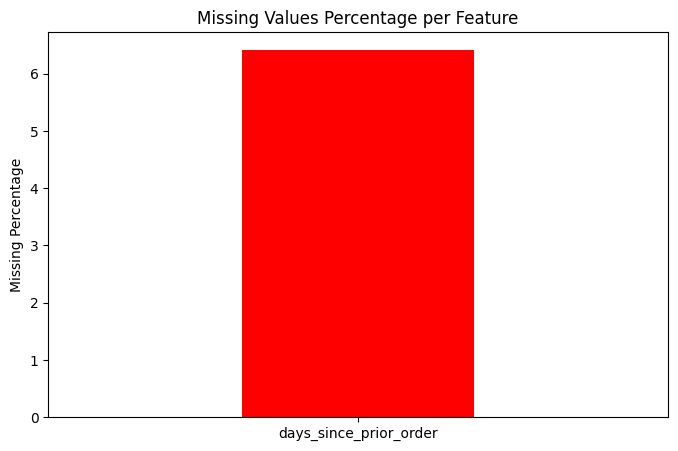

In [ ]:
#cheking for null values
missing_values = Full_DataSet.isnull().sum()
missing_values = missing_values[missing_values > 0]
print( missing_values )
print("=="*40 )
missing_percent = (missing_values / len(Full_DataSet)) * 100
print(f"Percentage of missing values in columns\n {missing_percent}", )

missing_percent.plot(kind='bar', figsize=(8, 5), width=0.3, color='red', rot=0)
plt.ylabel("Missing Percentage")
plt.title("Missing Values Percentage per Feature")
plt.show()
# هاي مش قيم مفقوده بالغلط هاي بتدل انه الزبون اول مره بيطلب فمفيش عندو قيمه ل days_since_prior_order

Distribution plots for numeric features and target(s) (histogram, density).


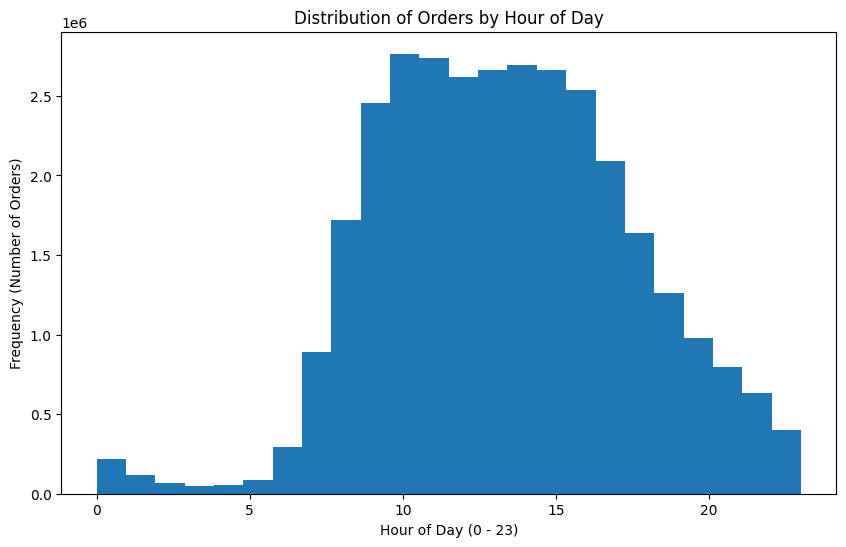

In [ ]:
# لازم نختار الاعمده الرقميه الي الها معنى او بتفيدنا لو عملنا الها هستوغرام او دينستي بالاحرى مين مهم افهم الديستربويشن تبعو
Full_DataSet['order_hour_of_day'].plot(kind='hist', bins=24, figsize=(10, 6), title='Distribution of Orders by Hour of Day')

#Histogram (المدرج التكراري) رسمة أعمدة بتبين الكمية في كل فترة

plt.xlabel('Hour of Day (0 - 23)') # سمينا المحور عشان الدكتور يفهم

plt.ylabel('Frequency (Number of Orders)')
plt.show()

#بنلاحظ  فوق الوقت الي بكون فيه وقت الذروه للزباين متى بكون باليوم

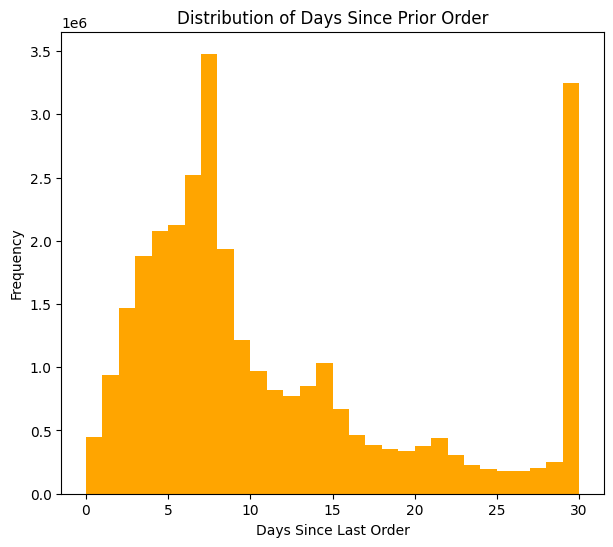

In [ ]:
Full_DataSet['days_since_prior_order'].plot(kind='hist', bins=30, figsize=(7, 6), color='orange', title='Distribution of Days Since Prior Order')

plt.xlabel('Days Since Last Order')
plt.ylabel('Frequency')
plt.show()

In [ ]:
#Weekly shoppers (peak at 7 days) and Monthly shoppers (peak at 30 days). The spike at 30 days also includes customers who haven't ordered for more than a month

In [ ]:
'''# 1. نأخذ عينة عشوائية (10% مثلاً) عشان الرام ما تنفجر
# هذا العمود يمثل "ساعات اليوم" من 0 لـ 23
sample_hours = Full_DataSet['order_hour_of_day'].sample(frac=0.1, random_state=42)

# 2. الرسم


plt.figure(figsize=(10, 6))

sample_hours.plot(kind='kde', color='green', title='Density Plot of Order Hour of Day')

plt.xlabel('Hour of Day (0-23)')
plt.xlim(0, 23) # عشان نحصر الرسمة في حدود اليوم
plt.show()

#الدينستي بعطينا هون تفاصيل اكثر او معبر اكثر بس بوخذ وقت اكثر للامانه '''


'# 1. نأخذ عينة عشوائية (10% مثلاً) عشان الرام ما تنفجر\n# هذا العمود يمثل "ساعات اليوم" من 0 لـ 23\nsample_hours = Full_DataSet[\'order_hour_of_day\'].sample(frac=0.1, random_state=42)\n\n# 2. الرسم\n\n\nplt.figure(figsize=(10, 6))\n\nsample_hours.plot(kind=\'kde\', color=\'green\', title=\'Density Plot of Order Hour of Day\')\n\nplt.xlabel(\'Hour of Day (0-23)\')\nplt.xlim(0, 23) # عشان نحصر الرسمة في حدود اليوم\nplt.show()\n\n#الدينستي بعطينا هون تفاصيل اكثر او معبر اكثر بس بوخذ وقت اكثر للامانه '

Categorical cardinality analysis (barplots / top-k frequencies).

In [ ]:
# first we need to do some cardinality checking for the catorgorical features
categorical_cols = Full_DataSet.select_dtypes(include=['category']).columns
categorical_cols



Index(['eval_set', 'product_name', 'department', 'aisle'], dtype='object')

In [ ]:
Full_DataSet["product_name"].value_counts() # هون بنلاحظ انو في منتجات كتير متكرره يعني الكارديناليتي عاليه فهاض العامود مابفيدني اعملو فيجواليزشن

product_name
Banana                                    472565
Bag of Organic Bananas                    379450
Organic Strawberries                      264683
Organic Baby Spinach                      241921
Organic Hass Avocado                      213584
                                           ...  
Unpeeled Apricot Halves in Heavy Syrup         0
12 Inch Taper Candle White                     0
Non-Dairy Coconut Seven Layer Bar              0
Pure Squeezed  Lemonade                        0
Protein Granola Apple Crisp                    0
Name: count, Length: 49688, dtype: int64

In [ ]:
# نعمل فحص للباقي
checking = ['department', 'aisle', 'product_name']

cardinality_counts = Full_DataSet[checking].nunique()
print("عدد الأنواع في كل عمود")
print(cardinality_counts)
# هون بنلاحظ الديبراتمنت فيه تنوع واطي فا بنقدر نعملو فيجواليز ونستفيد منه
# الممرات 134 يعتبر عاللي فامبنقدر نرسمو كلو رح نوخذ الاكثر تكرارا تمام نفس الحاله بنطبقها على اسماء المنتجات

عدد الأنواع في كل عمود
department         21
aisle             134
product_name    49677
dtype: int64


In [ ]:
# what is eval_set refer to ?
Full_DataSet['eval_set'].value_counts()
# هون شفنا انو هاض العامود بحتوي على داتا بتمثل الطلبات القديمه فهاض الاشي مابفيدني اني اعملو فيجواليز

eval_set
prior    32434489
test            0
train           0
Name: count, dtype: int64

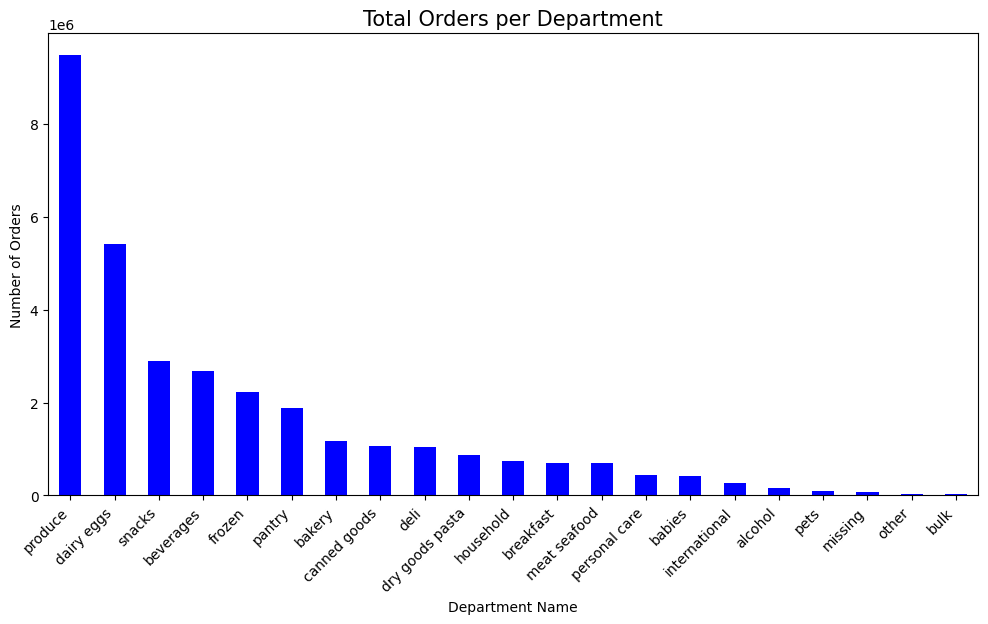

In [ ]:


#  بنرسمه كأعمدة Barplot
Full_DataSet['department'].value_counts().plot(kind='bar', figsize=(12,6) , color='blue')

plt.title('Total Orders per Department', fontsize=15)
plt.ylabel('Number of Orders')
plt.xlabel('Department Name')
plt.xticks(rotation=45, ha='right') # ميلنا الأسماء عشان نقرأها بوضوح
plt.show()

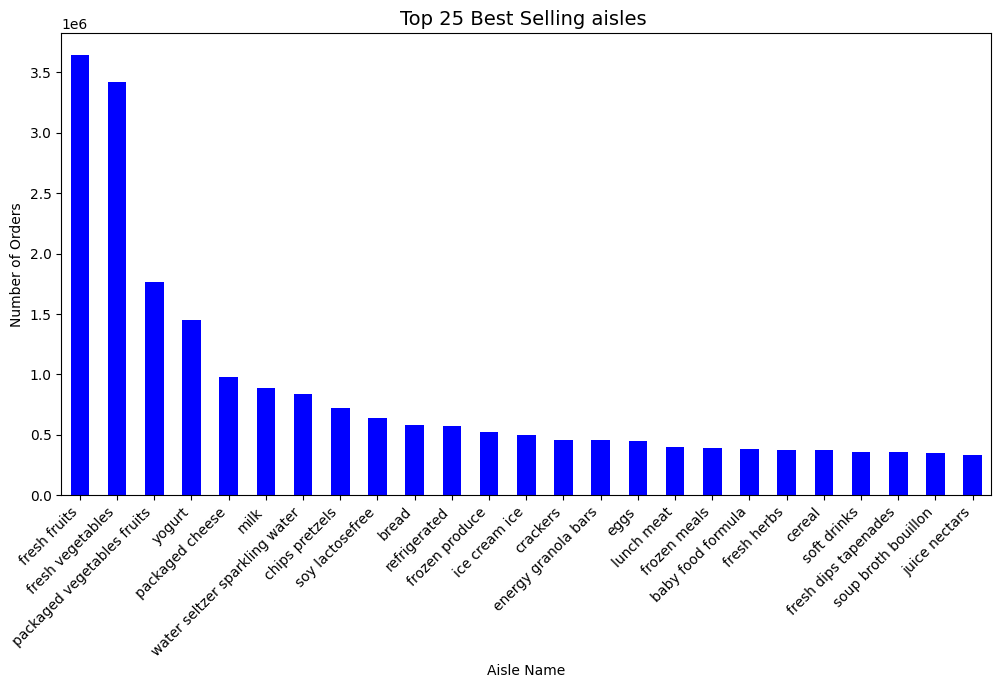

In [ ]:
top_aisles = Full_DataSet['aisle'].value_counts().head(25)
#  هون ممكن تسالني انت طيب كيف رتبتهم من الاكثر للاقل ؟ لان الميثود تاعت الفاليوز بالديفولت تاعها بترتبهم من الاكبر لاصغبر

top_aisles.plot(kind='bar',figsize=(12, 6), color='blue')


plt.title('Top 25 Best Selling aisles ', fontsize=14)
plt.ylabel('Number of Orders')
plt.xlabel('Aisle Name')
plt.xticks(rotation=45, ha='right') # ميلنا الكلام بزاوية 45 عشان ينقرأ بوضوح
plt.show()

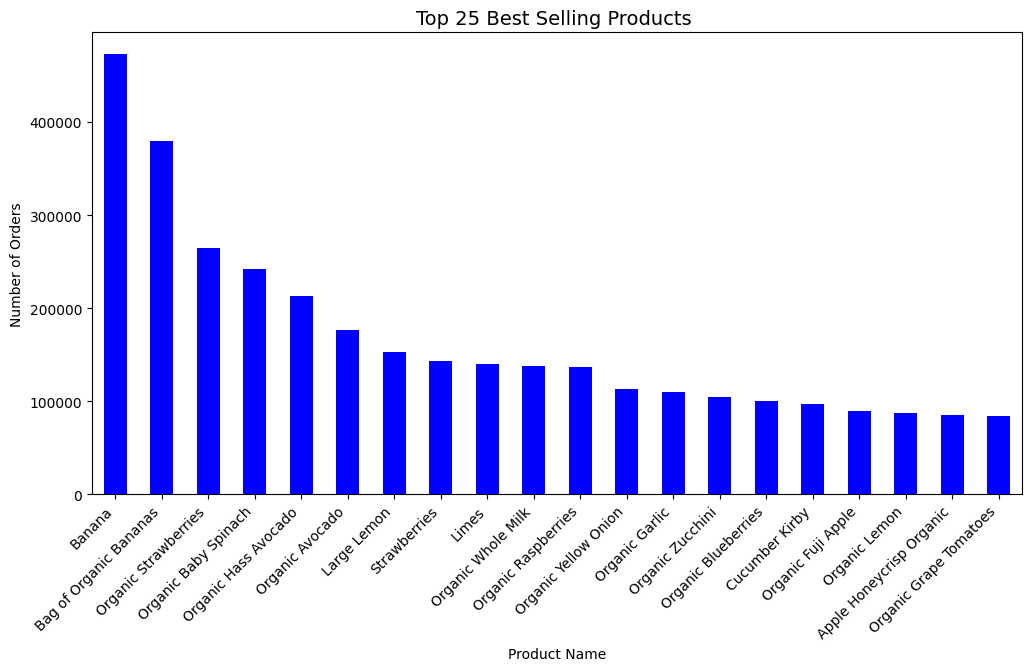

In [ ]:
products_for_visuals = Full_DataSet['product_name'].value_counts().head(20) # هون اخذنا اكثر 20 بس عشان يصير مقروء بشكل احسن

products_for_visuals.plot(kind='bar', figsize=(12, 6), color='blue')
plt.title('Top 25 Best Selling Products ', fontsize=14)
plt.ylabel('Number of Orders')
plt.xlabel('Product Name')
plt.xticks(rotation=45, ha='right')
plt.show()

• Correlation matrix, heatmap and pairwise scatter plots for selected numeric features.

In [ ]:
#  هاي الخطوة بدنا نعرف شو العوامل اللي بتخلي الزبون يعمل اعادة طلب او reorder
# في هاي الحاله لازم نختار الاعمده الرقميه الي الها سلوك او بمعنى اصح الها معنى

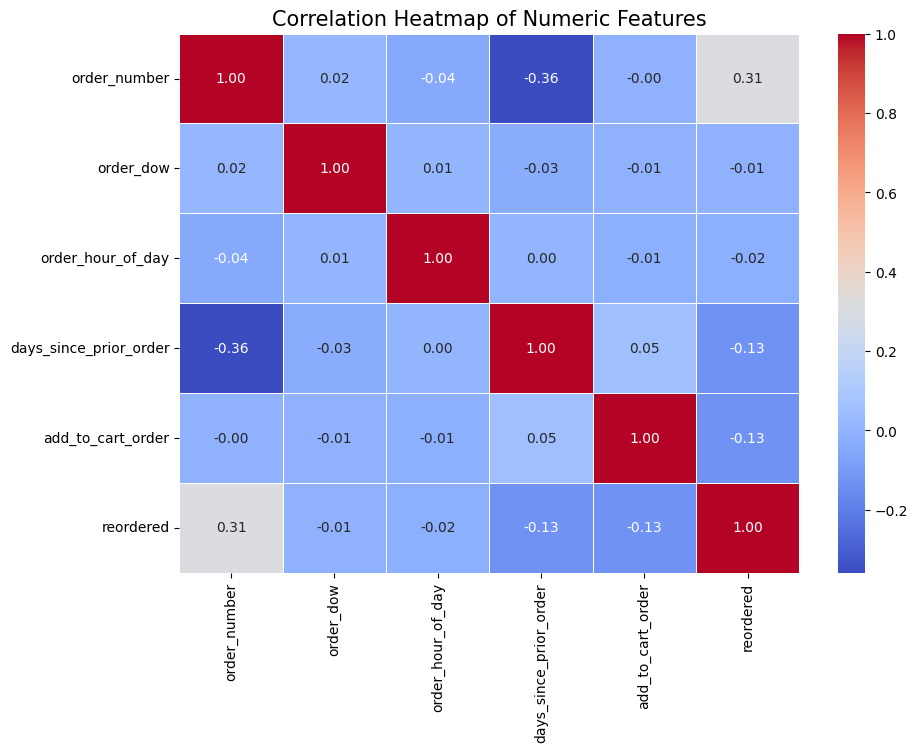

In [ ]:
selected_features = [
    'order_number',
    'order_dow',
    'order_hour_of_day',
    'days_since_prior_order',
    'add_to_cart_order',
    'reordered' # هاض العامود الي بدنا نعرف شو العوامل الي بتأثر عليه مثل ماقلنا فوق
]

# 2. حساب المصفوفة (Correlation Matrix)
# الدالة .corr() هي العقل المدبر اللي بيحسب العلاقات
corr_matrix = Full_DataSet[selected_features].corr()


# annot=True: عشان يكتب الرقم جوا المربع
# cmap='coolwarm': ألوان (أحمر للحار/الموجب، أزرق للبارد/السالب)
# fmt='.2f': منزلتين عشريتين بس
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=False)

plt.title('Correlation Heatmap of Numeric Features', fontsize=15)
plt.show()

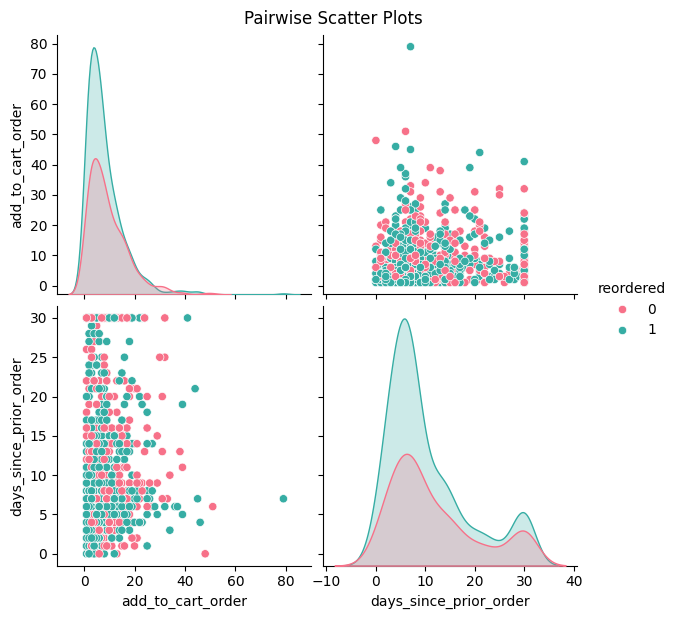

In [ ]:
# 1. نأخذ عينة صغيرة جداً (1000 سطر) عشان الرسم يكون خفيف وواضح
# Scatter Plot بيموت لو الداتا كبيرة
scatter_sample = Full_DataSet.sample(n=1000, random_state=42)

# 2. تحديد الأعمدة اللي بدنا نشوف علاقتها ببعض
# ركزنا على أهم 3 أعمدة عشان ما نضيع وقت
cols_to_plot = ['add_to_cart_order', 'days_since_prior_order', 'reordered']

# 3. رسم الـ Pairplot
# hue='reordered': عشان يلون النقاط (برتقالي للمكرر، أزرق للجديد)
sns.pairplot(scatter_sample[cols_to_plot], hue='reordered', palette='husl', height=3)

plt.suptitle('Pairwise Scatter Plots ', y=1.02)
plt.show()


In [ ]:
#طيب اللون الاخضر هون بمثل المنتجات المعاد شرائها بنلاحظ بالرسمه انو دايما بالبدايه ببدا الزبون يجيب اغراضو الي  متعود عليها
#بعدين بعد ما يجيبهم بجيب او بجرب اغراض جديده  مثل مابثمل اللون الزهري الي بمثل الاشياء الجديده
#الرسمة الشمال تحت النقط بتوريك إن المنتجات المكررة الخضراء دايما محجوز الها المقاعد الأولى بالسلة  بغض النظر عن كم يوم مر.

# الرسمة اليمين جبال بتأكد إن الناس بتتسوق بنظام أسبوعي أو شهري والمنتجات الجديدة والقديمة بتمشي على نفس هذا النظام.

• Time-of-day, day-of-week, and monthly seasonality plots

In [ ]:
hourrr=Full_DataSet['order_hour_of_day'].value_counts()
hourrr

order_hour_of_day
10    2764426
11    2738582
14    2691548
15    2664533
13    2663292
12    2620847
16    2537458
9     2456713
17    2089465
8     1719973
18    1637923
19    1259401
20     977038
7      891937
21     796370
22     634734
23     402620
6      290795
0      218948
1      115786
5       88062
2       69434
4       53283
3       51321
Name: count, dtype: int64

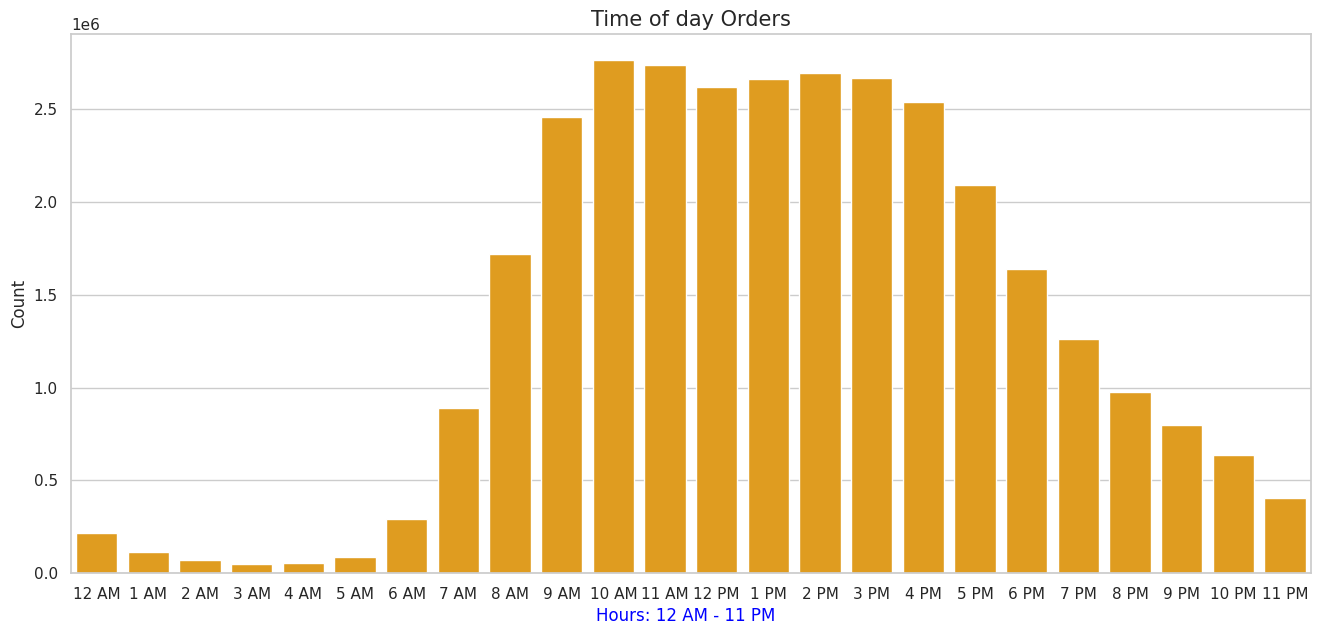

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(16, 7))


# هون لازم قبل مانرسم نجهز الداتا لانها عباره عن مليون سطر فا لازم نرتبها اول حسب التكرار بعدين بنرتبها حسب الاندكس تصاعدني
hour_counts = Full_DataSet['order_hour_of_day'].value_counts().sort_index()
#لو تركناها هيك لاحظت رح تطلع معنا الرسمه الساعات من صفر ل 23 فا حيكون شوي مش مقروء الوضع فا افترحت لو بدنا نوري هالرسمه لاي حد لو نزبط الاندكس
#ونخليه بنظام am و pm
#بكون احسن ليش فقط عشان نخليه مقروء واريح للعين اكثر
labels_of_hours = [
    "12 AM", "1 AM", "2 AM", "3 AM", "4 AM", "5 AM",
    "6 AM", "7 AM", "8 AM", "9 AM", "10 AM", "11 AM",
    "12 PM", "1 PM", "2 PM", "3 PM", "4 PM", "5 PM",
    "6 PM", "7 PM", "8 PM", "9 PM", "10 PM", "11 PM"
]
# x=labels_of_hours (الساعات)
# y=hour_counts.values (عدد الطلبات)
#هون اخترنا بار بلوت عشان سريع وبرضو برسملنا ال 24 عمود بسرعه عاليه
sns.barplot(x=labels_of_hours, y=hour_counts.values, color='orange',)

plt.title('Time of day Orders', fontsize=15)
plt.xlabel('Hours: 12 AM - 11 PM  ', fontsize=12,color='blue')
plt.ylabel('Count', fontsize=12)
plt.show()

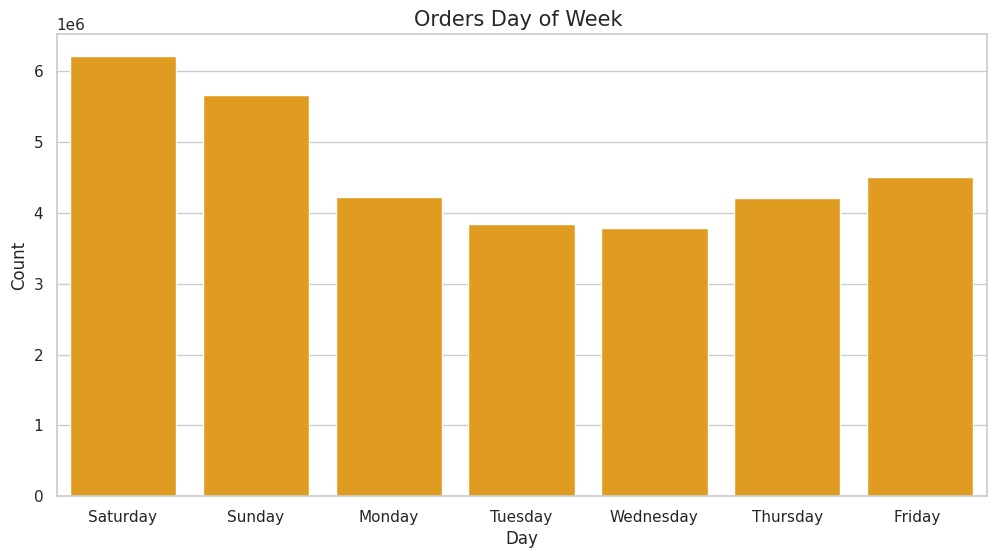

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# رح يطلع معنا 7 أرقام من 0 ـ 6
day_counts = Full_DataSet['order_dow'].value_counts().sort_index()

#بنرتبهم كمان مره زي ماعملنا فوق
 # الويك إند عند الاجانب ببدا من السبت فهو رح يكون رقم صفر
days_labels = ["Saturday",  "Sunday", "Monday",  "Tuesday", "Wednesday", "Thursday","Friday "]



sns.barplot(x=days_labels, y=day_counts.values, color="orange")

plt.title('Orders Day of Week ', fontsize=15)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Day', fontsize=12)

plt.show()
#بنلاحظ انو بالويكند اعلى طلبات وهاض المنطقي لانو الناس بتكون معطله

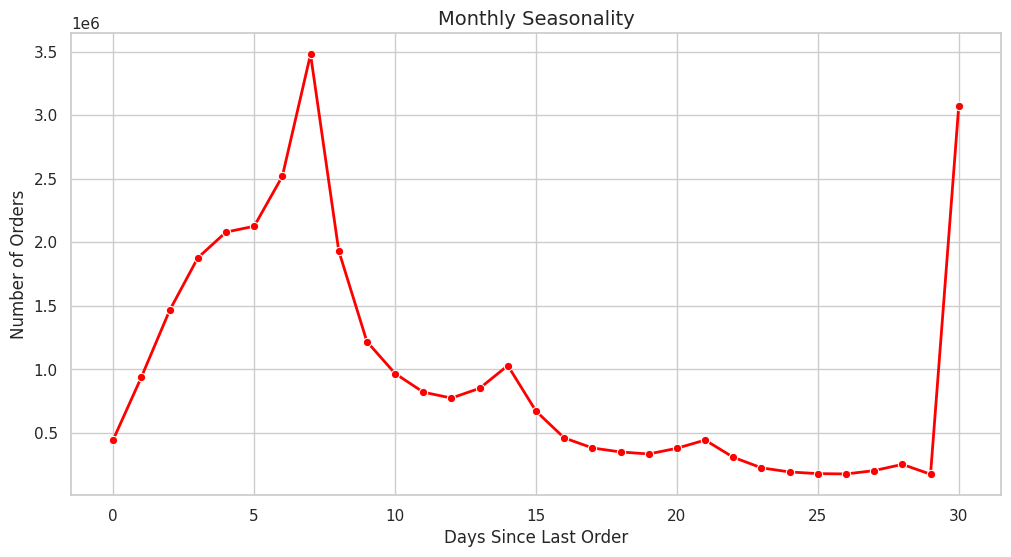

In [ ]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

#  هون رح نستخدم هاض الكولوم لانو انسب اشي للمنثلي لانو مافي عنا بالداتا سيت كولم عن الاشهر
days_of_month_counts = Full_DataSet['days_since_prior_order'].value_counts().sort_index()
#رح نستخدم اللاين بلوت عشان نوضح التغيرات بشكل افضل
sns.lineplot(x=days_of_month_counts.index, y=days_of_month_counts.values, marker='o', color='red', linewidth=2)

# 3. تحسين المحاور
plt.title('Monthly Seasonality', fontsize=14)
plt.xlabel('Days Since Last Order', fontsize=12)
plt.ylabel('Number of Orders', fontsize=12)
plt.show()
#بنلاحظ في قمه عند ال 7 و 30 يوم هاض يعني انو الزبون كل اسبوع غالبا بيجي يشتري وفي زباين بتيجي كل شهر او اكثر من شهر هاض كلو بنحط عند ال 30

3: cleaning


In [ ]:
# del Full_DataSet["aisle"]
# del Full_DataSet["department"]
# del Full_DataSet["eval_set"]

print(Full_DataSet.isnull().sum())
print("---------------------------------------")

#كان هدفي اشوف ال نان من هون بس ما زبطت ف شفتها من الملف نفسه
Full_DataSet.head(10)
#اللي بين معي انه ال نان بكون موجود لكل اول اوردير بطلبه المستخدم\الزبون

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
department                      0
aisle                           0
dtype: int64
---------------------------------------


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,dairy eggs,eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,produce,fresh vegetables
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,pantry,spices seasonings
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,pantry,oils vinegars
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,pantry,baking ingredients
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,produce,fresh vegetables
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,pantry,doughs gelatins bake mixes
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,pantry,spreads
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,produce,packaged vegetables fruits
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,dairy eggs,yogurt


In [ ]:
def check_outliers(Full_DataSet):

    out = ["order_id" , "product_id" , "user_id" , "aisle_id" , "department_id" , "eval_set"]
    Outliers_DF = []
    numeric_cols_all = Full_DataSet.select_dtypes(include=[np.number]).columns.tolist()


    for i in numeric_cols_all:
        if i not in out:
            Outliers_DF.append(i)

    col_length = len(Outliers_DF)
    row = (col_length // 3) + 1
    plt.figure(figsize=(20 , 5 * row))

    #لاني بحتاج index + value خلال التكرار لرسم subplots.
    #عشان هيك استخدمت enumerate
    for i , col in enumerate(Outliers_DF):
        plt.subplot(row , 3 , i + 1)

        plot_data = Full_DataSet[col].dropna().sample(n = min(100000 , len(Full_DataSet)))

        sb.boxplot(x = plot_data , color="lightblue")
        plt.title(col , fontsize = 12)
        plt.xlabel(" ")

    plt.tight_layout()
    plt.show()

In [ ]:
#print(check_outliers(Full_DataSet))

#من خلال الرسم بين معي انه الحد الفاصل بين اكبر قيمه والاوتلايرز هي 30
Full_DataSet["add_to_cart_order"] =  np.where(Full_DataSet["add_to_cart_order"] > 30 , 30 , Full_DataSet["add_to_cart_order"])
#ونفس المبدأ بنطبق هون
Full_DataSet["order_number"] =  np.where(Full_DataSet["order_number"] > 50 , 50 , Full_DataSet["order_number"])

print(Full_DataSet["add_to_cart_order"].describe())
print()
print(Full_DataSet["order_number"].describe())



count    3.243449e+07
mean     8.246521e+00
std      6.683168e+00
min      1.000000e+00
25%      3.000000e+00
50%      6.000000e+00
75%      1.100000e+01
max      3.000000e+01
Name: add_to_cart_order, dtype: float64

count    3.243449e+07
mean     1.612285e+01
std      1.457543e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.100000e+01
75%      2.400000e+01
max      5.000000e+01
Name: order_number, dtype: float64


In [ ]:
Full_DataSet.dtypes

order_id                     int32
product_id                   int32
add_to_cart_order            int16
reordered                     int8
user_id                      int32
eval_set                  category
order_number                  int8
order_dow                     int8
order_hour_of_day             int8
days_since_prior_order     float32
product_name              category
aisle_id                     int32
department_id                int32
department                category
aisle                     category
dtype: object

In [ ]:
imputer = SimpleImputer(strategy = "constant" , fill_value = 0)
#بعد ما تفرجت عالداتا من الاكسل , اكتشفت انه النان موجوده بس عند اول طلب للمستخدم , يعني ما عنده طلب مسبق
#الموديل لما يشوف الصفر رح يقلك هاض المستخدم جديد , وعشان هيك ما عنده طلبات مسبقه
Full_DataSet["days_since_prior_order"] = imputer.fit_transform(Full_DataSet["days_since_prior_order"].values.reshape(-1,1))

DF = pd.DataFrame(Full_DataSet , columns = Full_DataSet.columns)

#DF.to_csv('archive/full_instacart_data.csv', index=False)
print(DF.isnull().sum())



order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
department                0
aisle                     0
dtype: int64


4: feature engineering (mandatory list)

In [ ]:
#total orders per user يعني كل مستخدم كم مره فات المحل واشترى يعني كم طلب عملو بشكل كامل مش كم منتج اشتراه بحياتو
# طيب هون القروب باي بيجمعلي كل الداتا تبع كل يوزر ايدي لحال
#بعدين بقله لكل يوزر بدي كولوم الاوردر نمبر تمام هسا الاورودر نمبر لكل زبون بمثل كل زبون كم طلب عملو لحد الان فا لو اخذتلو ال ماكس
#لو اخذت الماكس رح تعطيني رقم اخر فاتوره والي بمثل عدد الطلبات الكلي لكل زبون طيب ممكن تسالني كان بمكاني اختار كاونت مش ماكس صح كلامك لكن
#الداتا الي عندي او كولوم الاوردر نمبر يعني بحتوي على ارقام الطلبات مش عدد الطلبات فلو اخذت كاونت رح يطلعلي عدد المنتجات مش عدد الطلباتؤ
#استخدمنا الريست اندكس عشان يرجعلي الداتا فريم مش سيرييز لانو قروب باي بيرجع سيرييز افتراضيا وبتخرب الداتا بصير اليوزر هو كولوم الاندكس
user_total_orders = DF.groupby('user_id')['order_number'].max().reset_index()
# 3. بنسمي العمود اسم واضح عشان ما نتخربط بعدين
user_total_orders.columns = ['user_id', 'user_total_orders']

print(user_total_orders.head())

   user_id  user_total_orders
0        1                 10
1        2                 14
2        3                 12
3        4                  5
4        5                  4


In [ ]:
#  average basket size
#هذه الميزة بتحدد القدرة الشرائية Purchasing Power
#وبتحدد نمط التسوق عند الزبون يعني بعرف الزبون الي عادته يشتري مثلا 50 غرض هاض زبون بمتوسط سلة كبيرة فا بهمني انو المودل ممكن
#بهمني انو المودل ممكن يشوف هالشي ويستفيد منه بحيث لو كان شاري 3 اغراض بس يضل يقترح عليه لانو هالزبون من عادتو يشتري كثير

#============================================================================================================

#طيب السواال كيف بنحسبها ؟ بنحسبها عن طريق انو بنجيب لكل زبون كم المنتجات الي اشتراها بشكل كلي
#بعدين بنجيب كم طلب عملو بشكل كلي
#بعدين بنقسم المجموع على العدد
#============================================================================================================
#هون اولا عشان نجيب مجموع المنتجات الي اشتراها كل زبون بنجيب كولوم البروودكت ايدي وبنعمللو كاونت هيك بنعد كل المنتجات الي اشتراها
#بعدين بنجيب كولوم الاوردر نمبر وبناخد الماكس زي ما شرحنا فوق عشان نعرف كم طلب عملو بشكل كلي

#واستخدمنا ميثود الاقريقيت الي بتتيحلي اعمل اكشنز متعدده على كولمز مختلفه بنفس الوقت بدل ما اعمل قروب باي مرتين
basket_data = DF.groupby('user_id').agg({ 'product_id':'count', 'order_number': 'max'}).reset_index()

# مجرد تسميت الكولمز بشكل واضح بس
basket_data.columns = ['user_id', 'total_items_bought', 'total_orders_made']

#الحسبه
basket_data['avg_basket_size'] = basket_data['total_items_bought'] / basket_data['total_orders_made']

print(basket_data.head())

   user_id  total_items_bought  total_orders_made  avg_basket_size
0        1                  59                 10         5.900000
1        2                 195                 14        13.928571
2        3                  88                 12         7.333333
3        4                  18                  5         3.600000
4        5                  37                  4         9.250000


In [ ]:
#  User-Level Features full
#هون لازم نعمل سورت اول عشان اخر مطلوب اللاست لاخر طلب فا ممكن يكون اخر طلب الي بجيبو مش هو اخر طلب عملو
#بس الجهاز عندي بتحملش
# Full_DataSet.sort_values(['user_id', 'order_number'], inplace=True)
user_features = DF.groupby('user_id').agg({
      # 1. Total #Orders
    'order_number': 'max',
    # 2. هاض بساعدنا نعرف كم منتج اشتراها كل زبون بشكل كلي
     'product_id': 'count',
    # 3. Reorder Ratio
    'reordered': 'mean',

   #هون حسبنا اخر مطلوبين بخطوه وحده بدل ما نعمل قروب باي مرتين
    'days_since_prior_order': ['mean', 'last']
}).reset_index()


user_features.columns = ['user_id',  'user_total_orders',  'user_total_items', 'user_reorder_ratio','user_avg_days_between', 'user_days_since_last_order'  ]

# Basket Size
user_features['user_avg_basket_size'] = user_features['user_total_items'] / user_features['user_total_orders']

#هاض العامود مش ضروري بعد ما حسبنا الافريج مابنحتاجه
del user_features['user_total_items']

display(user_features.head())

,user_id,user_total_orders,user_reorder_ratio,user_avg_days_between,user_days_since_last_order,user_avg_basket_size
0,1,10,0.694915,18.542374,19.0,5.900000
1,2,14,0.476923,14.902564,30.0,13.928571
2,3,12,0.625000,10.181818,7.0,7.333333
3,4,5,0.055556,11.944445,0.0,3.600000
4,5,4,0.378378,10.189189,0.0,9.250000


Product-level features

In [ ]:
# --- Product-Level Features ---

# هالمره التجميع رح يكون حسب المنتج مش حسب اليوزر
product_features = DF.groupby('product_id').agg({

    #  Popularity
    #هون شو ممكن يفيدنا هون قصدو من البوبولاريتي انه نعرف كم مرة انباع هاد المنتج ممكن من خلاله نعرف  اكثر المنتجات بينباع او وين اقل منتج
    'user_id': 'count',
    # ليش user_id؟ وليش count؟
    # عشان نعد كم زبون اشترى هاد المنتج لانو كل سطر بيمثل  عنا عمليه شراء.
    #====================================================================================
    #  Reorder Rate
    #هون بنحسب نسبة اعادة الطلبات للمنتج
    'reordered': 'mean',
    #هاي واضحه من اسمها بدهاش اشي
    #====================================================================================
    # Average  Position
    #طيب ممكن تسالني ليش اخترنا هاض الكولوم بالذات رح لانه بمثل ترتيب المنتج داخل السلة فلو اخذنا المين رح يعطينا ترتيب المنتج داخل السلة زي ماهو طالب
    'add_to_cart_order': 'mean'

}).reset_index()

product_features.columns = [ 'product_id', 'product_total_purchases', 'product_reorder_rate', 'product_avg_cart_position' ]

display(product_features.head())

,product_id,product_total_purchases,product_reorder_rate,product_avg_cart_position
0,1,1852,0.613391,5.739741
1,2,90,0.133333,9.677778
2,3,277,0.732852,6.321300
3,4,329,0.446809,9.468085
4,5,15,0.600000,6.466667


User×Product interaction features

In [ ]:
#UserxProduct Interaction Features
#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

#دمجتها من هسا عشان اجرب اشغل user_days_since_last_order لانها مش جزء من الداتا الاساسيه ف ما اشتغل الكود
DF = DF.merge(user_features[['user_id' , 'user_days_since_last_order']] , on = 'user_id', how = 'left')

prior_df = DF[DF['eval_set'] == 'prior'].copy()
# uxp_features = DF.groupby(['user_id', 'product_id']).agg({

uxp_features = prior_df.groupby(['user_id', 'product_id']).agg({
# Total Purchases of Product by User
#هون عشان نجيبها كان ممكن نستخدم اي عمود بس بدنا واحد  بس المهم نعد كم مرة هاد الزبون اشترا هاد المنتج
#طب ليش اخترت هاض الكولوم بالذات اختصارا للوقت بس عشان المطلوب الثاني رح ارجع اطلبه تمام
#====================================================================================

# Reorder Probability of Product by User
#هون استخدمنا برضو بنفس العامود بس اخذنا المين عشان يعطينا النسبة الي طلبها الزبون من هاد المنتج
    'reordered': ['count', 'mean'],

    'user_days_since_last_order': 'max'    # هاي مش عارف اعملها علقت كيف ممكن نجيب ال   days since last purchase by     user_days_since_last_order  days_since_prior_order
}).reset_index()

# 2. تسمية الأعمدة بشكل واضح (عشان الدكتور يفهم كل عمود شو هو)
uxp_features.columns = [
    'user_id',
    'product_id',
    'uxp_total_bought',
    'uxp_reorder_ratio',
    'uxp_days_last_order_'
]

display(uxp_features.head(20))

,user_id,product_id,uxp_total_bought,uxp_reorder_ratio,uxp_days_last_order_
0,1,196,10,0.900000,19.0
1,1,10258,9,0.888889,19.0
2,1,10326,1,0.000000,19.0
3,1,12427,10,0.900000,19.0
4,1,13032,3,0.666667,19.0
5,1,13176,2,0.500000,19.0
6,1,14084,1,0.000000,19.0
7,1,17122,1,0.000000,19.0
8,1,25133,8,0.875000,19.0
9,1,26088,2,0.500000,19.0


Temporal features: hour/day/month/year, season, holiday flags (if available).

In [ ]:
# طيب هون المطلوب منا بالتيمبورال فيشترز انو نزبط الوقت مثلا نخليه صبح ومسا ومثلا الايام نقسمها ايام عاديه وايام عطله والشهر
#بس مبادايا الشهر والسنه والموسم مابنقدر لانو مامعنا معلومات عنها  في رح نكتفي بالساعات واليوم
#نبدا بالساعات هسا التوقيت  عنا من 0 ل 23 فممكن نقسمهم لثلاث فترات
def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Midnight'
DF['time_of_day'] = DF['order_hour_of_day'].apply(time_of_day)
print(DF['time_of_day'].head(10))
print("=="*40)
#طيب قلنا للايام بنقسمها لايام عاديه وايام عطله
#وزي مابنعرف بالداتا الي عندي السبت والاحد همه العطله فرقمهم بكون 0 و 1
#هون اختصارا على حالنا لقدام خليت الكولوم الجديد عباره عن ارقام 0 و 1 بدل ما اخليها نصوص عشان اسهل التعامل معها بعدين
def day_type(day):
    if (day == 0) or (day == 1):
        return 1 # طبعا واحد بتعني انها شسمو ويكند
    else:
        return 0
DF['is_weekend'] = DF['order_dow'].apply(day_type)
print(DF['is_weekend'].head(30))
#حطيت 30 لانو خفت كلها صفار ههههه يسعد ربك


0    Morning
1    Morning
2    Morning
3    Morning
4    Morning
5    Morning
6    Morning
7    Morning
8    Morning
9    Evening
Name: time_of_day, dtype: object
0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
16    0
17    1
18    1
19    1
20    1
21    1
22    1
23    1
24    1
25    1
26    1
27    1
28    1
29    1
Name: is_weekend, dtype: int64


In [ ]:
# --- 5. Aggregations over Windows (Last 3 Orders) - بدون Lambda ---

# 1. تجهيز الداتا: بنحسب حجم السلة لكل طلب (جدول صغير وخفيف)
orders_summary = DF.groupby(['user_id', 'order_number']).size().reset_index(name='basket_size')

# 2. الترتيب (مهم جداً): عشان لما نقول "آخر 3" يكونوا عنجد آخر 3 زمنياً
orders_summary = orders_summary.sort_values(['user_id', 'order_number'])

# 3. تعريف الفنكشن العادي (بدل اللمدا)
# هذا الفنكشن بياخذ عمود أرقام، وبحسب المتوسط المتحرك لآخر 3 قيم
def calculate_last_3_avg(series):
    # window=3: يعني خذ 3 قيم
    # min_periods=1: يعني حتى لو الزبون عنده طلب واحد بس، احسبله المعدل (ما ترجع Null)
    return series.rolling(window=3, min_periods=1).mean()

# 4. تطبيق الفنكشن على كل زبون
# transform: بتمسك الفنكشن اللي كتبناه فوق، وبتطبقه على كل "مجموعة" (زبون)
orders_summary['rolling_avg_3_orders'] = orders_summary.groupby('user_id')['basket_size'].transform(calculate_last_3_avg)

# 5. النتيجة النهائية
# احنا بهمنا "آخر وضع" وصله الزبون، فبناخذ آخر سطر لكل زبون
user_window_features = orders_summary.groupby('user_id').last().reset_index()

# ترتيب وتنظيف الجدول النهائي
user_window_features = user_window_features[['user_id', 'rolling_avg_3_orders']]
user_window_features.columns = ['user_id', 'u_avg_basket_last_3']

display(user_window_features.head(20))

,user_id,u_avg_basket_last_3
0,1,7.000000
1,2,14.666667
2,3,5.666667
3,4,4.000000
4,5,8.666667
5,6,4.666667
6,7,10.000000
7,8,16.333333
8,9,25.333333
9,10,30.666667


✅ تم حساب (Rolling Window) باستخدام فنكشن عادي!

At least one engineered non-linear feature : log transforms

In [ ]:
# افترض إنك حسبت user_features في الخطوة الأولى
# بدنا نحول عمود "عدد الطلبات" باستخدام اللوغاريتم
#هسا
print("=")
#هون طقعت ديسبلاي لانها اوضح بس من برنت
user_features['u_total_orders_log'] = np.log(user_features['user_total_orders'])

# حطيناهم جمب بعض عشان تشوف الفرق
print("user_total_orders trasform")
display(user_features[['user_total_orders', 'u_total_orders_log']].head(90))
#
#كمان فيتشر ثاني نعملو مش غلط
product_features['p_total_purchases_log'] = np.log(product_features['product_total_purchases'])

print("="*40)
print("product_ total_purchases transform")

display(product_features[['product_total_purchases', 'p_total_purchases_log']].head())

=
user_total_orders trasform


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,user_total_orders,u_total_orders_log
0,10,2.302734
1,14,2.638672
2,12,2.484375
3,5,1.609375
4,4,1.386719
...,...,...
85,17,2.833984
86,27,3.294922
87,7,1.946289
88,20,2.996094


product_ total_purchases transform


,product_total_purchases,p_total_purchases_log
0,1852,7.524021
1,90,4.499810
2,277,5.624018
3,329,5.796058
4,15,2.708050


In [ ]:
#بدي اسوي نسخه للاحتياط , هسا انا صرت بمرحله حرجه شوي و اي خطأ ممكن يدمر الداتا كامله ف الاحتياط واجب
final_df = DF.copy()

final_df = final_df.merge(user_features , on = 'user_id' , how = 'left')
#لاني دمجتهم من قبل , عملت هالحركه عشان اتأكد ما يصير عندي اي تكرار
final_df = final_df.drop(columns=[col for col in user_features.columns if col in final_df.columns and col != 'user_id'])

final_df = final_df.merge(user_features , on = 'user_id', how = 'left')
final_df = final_df.merge(product_features , on = 'product_id', how = 'left')
final_df = final_df.merge(uxp_features , on = ['user_id' , 'product_id'] , how = 'left')
final_df = final_df.merge(user_window_features , on = 'user_id' , how = 'left')

In [ ]:
print(final_df.shape)
print(DF.shape)
print()
print(final_df.isnull().sum())
final_df.head()

(32434489, 33)
(32434489, 18)

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order          0
product_name                    0
aisle_id                        0
department_id                   0
department                      0
aisle                           0
user_days_since_last_order_x    0
time_of_day                     0
is_weekend                      0
user_days_since_last_order_y    0
user_total_orders               0
user_reorder_ratio              0
user_avg_days_between           0
user_days_since_last_order      0
user_avg_basket_size            0
u_total_orders_log              0
product_total_purchases         0
product_reorder_rate            0
product_avg_cart_position       0
p_total_purchases

/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,...,user_avg_basket_size,u_total_orders_log,product_total_purchases,product_reorder_rate,product_avg_cart_position,p_total_purchases_log,uxp_total_bought,uxp_reorder_ratio,uxp_days_last_order_,u_avg_basket_last_3
0,2,33120,1,1,202279,prior,3,5,9,8.0,...,11.25,2.080078,19400,0.708454,6.775722,9.873028,5,0.800000,30.0,13.333333
1,2,28985,2,1,202279,prior,3,5,9,8.0,...,11.25,2.080078,67449,0.694465,7.455085,11.119127,5,0.800000,30.0,13.333333
2,2,9327,3,0,202279,prior,3,5,9,8.0,...,11.25,2.080078,6299,0.157962,9.784251,8.748146,1,0.000000,30.0,13.333333
3,2,45918,4,1,202279,prior,3,5,9,8.0,...,11.25,2.080078,744,0.272849,8.333333,6.612041,5,0.800000,30.0,13.333333
4,2,30035,5,0,202279,prior,3,5,9,8.0,...,11.25,2.080078,569,0.507909,8.407733,6.343880,3,0.666667,30.0,13.333333


In [ ]:
#بدي اختار الاعمده اللي لازم ازبط الميموري الهم
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 33 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   order_id                      int32   
 1   product_id                    int32   
 2   add_to_cart_order             int16   
 3   reordered                     int8    
 4   user_id                       int32   
 5   eval_set                      category
 6   order_number                  int8    
 7   order_dow                     int8    
 8   order_hour_of_day             int8    
 9   days_since_prior_order        float32 
 10  product_name                  category
 11  aisle_id                      int32   
 12  department_id                 int32   
 13  department                    category
 14  aisle                         category
 15  user_days_since_last_order_x  float32 
 16  time_of_day                   object  
 17  is_weekend                    int64   
 18  

In [ ]:
def reduce_memory_FE(df , col_name):

    for col in col_name:
        col_type = df[col].dtype

        if "int" in str(col_type):
            df[col] = df[col].astype("int32")

        elif "float" in str(col_type):
            df[col] = df[col].astype("float32")

        elif col_type == "object":
            df[col] = df[col].astype("category")

    return df
# import numpy as np

# def reduce_memory_FE(df, col_name):
#     for col in col_name:
#         # تأكد إن العمود موجود أصلاً عشان ما يضرب إيرور
#         if col not in df.columns:
#             continue

#         col_type = df[col].dtype

#         # التعامل مع الأرقام الصحيحة
#         if str(col_type)[:3] == 'int':
#             c_min = df[col].min()
#             c_max = df[col].max()

#             # إذا الرقم صغير (زي أيام الأسبوع أو الساعات) حوله لـ int8
#             if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
#                 df[col] = df[col].astype(np.int8)
#             # إذا أكبر شوي حوله لـ int16
#             elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
#                 df[col] = df[col].astype(np.int16)
#             # غير هيك خليه int32
#             else:
#                 df[col] = df[col].astype(np.int32)

#         # التعامل مع الكسور (ثبتها على float32 ممتاز)
#         elif 'float' in str(col_type):
#             df[col] = df[col].astype(np.float32)

#         # التعامل مع النصوص
#         elif col_type == "object":
#             df[col] = df[col].astype("category")

#     return df

# # القائمة تبعتك
# col_name = ["uxp_reorder_ratio" , "u_avg_basket_last_3" , "uxp_total_bought" ,
#             "p_total_purchases_log" , "product_avg_cart_position" , "product_reorder_rate" ,
#             "product_total_purchases" , "u_total_orders_log" , "user_avg_basket_size" ,
#             "user_reorder_ratio" , "is_weekend" , "time_of_day"]

# # ⚠️ انتبه: تأكد هل اسم الداتا فريم عندك DF ولا final_df ؟
# # حسب الخطوات اللي مشينا عليها قبل شوي، المفروض اسمها DF
# DF = reduce_memory_FE(DF, col_name)

# print("✅ تم ضغط أعمدة الـ Features بذكاء!")
# print(DF[col_name].dtypes) # عشان تتأكد بعينك

In [ ]:
col_name = ["uxp_reorder_ratio" , "u_avg_basket_last_3" , "uxp_total_bought" , "p_total_purchases_log" , "product_avg_cart_position" , "product_reorder_rate" , "product_total_purchases" , "u_total_orders_log" , "user_avg_basket_size" , "user_reorder_ratio" , "is_weekend" , "time_of_day"]

final_df = reduce_memory_FE(final_df, col_name)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 33 columns):
 #   Column                        Dtype   
---  ------                        -----   
 0   order_id                      int32   
 1   product_id                    int32   
 2   add_to_cart_order             int16   
 3   reordered                     int8    
 4   user_id                       int32   
 5   eval_set                      category
 6   order_number                  int8    
 7   order_dow                     int8    
 8   order_hour_of_day             int8    
 9   days_since_prior_order        float32 
 10  product_name                  category
 11  aisle_id                      int32   
 12  department_id                 int32   
 13  department                    category
 14  aisle                         category
 15  user_days_since_last_order_x  float32 
 16  time_of_day                   category
 17  is_weekend                    int32   
 18  

In [ ]:
final_df = final_df.drop(columns=['user_days_since_last_order_x' ,
                                  'user_days_since_last_order_y'] ,
    errors='ignore'
)

#ما عرفت اقلل الذاكره اكثر من هيك 😢
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 31 columns):
 #   Column                      Dtype   
---  ------                      -----   
 0   order_id                    int32   
 1   product_id                  int32   
 2   add_to_cart_order           int16   
 3   reordered                   int8    
 4   user_id                     int32   
 5   eval_set                    category
 6   order_number                int8    
 7   order_dow                   int8    
 8   order_hour_of_day           int8    
 9   days_since_prior_order      float32 
 10  product_name                category
 11  aisle_id                    int32   
 12  department_id               int32   
 13  department                  category
 14  aisle                       category
 15  time_of_day                 category
 16  is_weekend                  int32   
 17  user_total_orders           int8    
 18  user_reorder_ratio          float32 
 19

In [ ]:
#final_df.to_csv('archive/new_instacart_data.csv', index=False)

5: Dimensionality & collinearity

In [ ]:
id_cols = ['order_id', 'user_id', 'product_id', 'aisle_id', 'department_id']
low_cols = ["department_id", "order_dow" , "time_of_day"]
high_cols = ["user_id", "product_id", "aisle_id"]

final_df[high_cols] = final_df[high_cols].astype(str)
#هالحركه سويتها بعد ما متت وانا بحلل الكود بعد ما طلعلي التنبيه هاض
#Warning: No categorical columns found. Calling 'transform' will only return input data.
#لما راجعت الانكوديرز تذكرت انه التارقيت ما بشتغل غير مع نصوص والاعمده اللي انا معطيه اياهم رقميات

# target_col = "reordered"
# Frequency_col = "product_name"

# #عدد الاعمده كبير جدا فقلت بعمل لوب + استثناءات عشان اريح راسي
# num_cols = (final_df.drop(columns=[target_col]).select_dtypes(include=["int32" , "float32"]).columns.tolist())
# num_cols = [c for c in num_cols if c not in id_cols]

In [ ]:

target_col = "reordered"
Frequency_col = "product_name"

#عدد الاعمده كبير جدا فقلت بعمل لوب + استثناءات عشان اريح راسي
num_cols = (final_df.drop(columns=[target_col]).select_dtypes(include=["int32" , "float32"]).columns.tolist())
num_cols = [c for c in num_cols if c not in id_cols]

In [ ]:
#بدي استخدم VIF , هاض عباره عن فنكشن رياضي ببين قديش في ارتباط وتكرار بين الاعمده نفسهم
#الهدف منه اني اشوف شو في اعمده فيهم تشابه كبير وبقدمو نفس المعلومه تقريبا عشان احذف واحد منهم

SAMPLE_SIZE = 50000
V = final_df[num_cols].sample(n=SAMPLE_SIZE , random_state = 42)

vif = pd.DataFrame()
vif["feature"] = V[num_cols].columns
vif["VIF"] = [variance_inflation_factor(V.values , i) for i in range(V.shape[1])]

#تحت 5 ممتاز
#بين ال 6 وال 10 مقبول
#اكثر من هيك بدك تشوف شو و وين في ترابط غير مهم وتبلش تحذف
#ال inf حذف مباشره

vif.sort_values("VIF" , ascending = True)

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
1,is_weekend,1.582424
7,product_total_purchases,2.203586
14,u_avg_basket_last_3,2.693228
11,uxp_total_bought,3.026090
0,days_since_prior_order,3.481639
12,uxp_reorder_ratio,6.942023
5,user_avg_basket_size,8.180552
3,user_avg_days_between,12.289076
9,product_avg_cart_position,27.265207
8,product_reorder_rate,30.917331


In [ ]:
vif["feature"] = V[num_cols].columns
vif["VIF"] = [variance_inflation_factor(V.values , i) for i in range(V.shape[1])]

#تحت 5 ممتاز
#بين ال 6 وال 10 مقبول
#اكثر من هيك بدك تشوف شو و وين في ترابط غير مهم وتبلش تحذف
#ال inf حذف مباشره

vif.sort_values("VIF" , ascending = True)

/usr/local/lib/python3.12/dist-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,feature,VIF
1,is_weekend,1.582424
7,product_total_purchases,2.203586
14,u_avg_basket_last_3,2.693228
11,uxp_total_bought,3.026090
0,days_since_prior_order,3.481639
12,uxp_reorder_ratio,6.942023
5,user_avg_basket_size,8.180552
3,user_avg_days_between,12.289076
9,product_avg_cart_position,27.265207
8,product_reorder_rate,30.917331


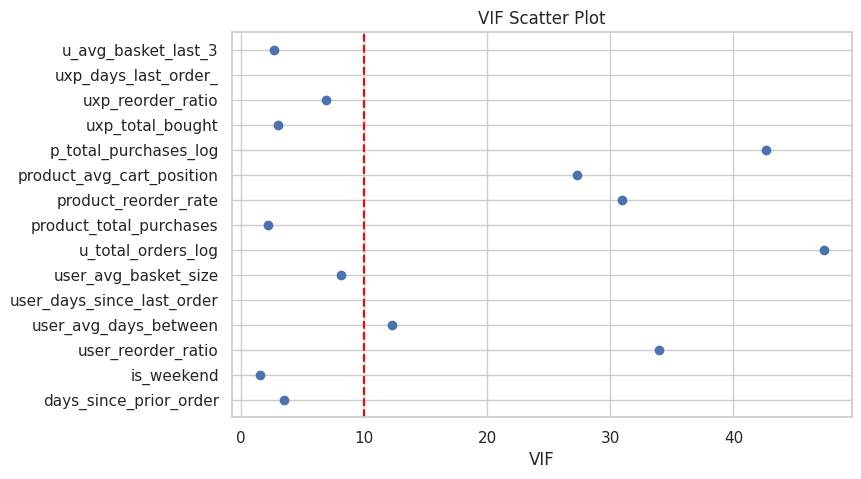

In [ ]:
plt.figure(figsize = (8 , 5))
plt.scatter(vif["VIF"] , vif["feature"])
plt.axvline(10 , color = 'red' , linestyle = '--')
plt.xlabel("VIF")
plt.title("VIF Scatter Plot")
plt.show()


In [ ]:
#حذفت القيم اللانهائيه , والقيم اللي فيها النسبه عاليه , لانهم بدلو على تكرار وتشابه المعلومات , يعني لو خليتهم كلهم زي كأني مكرر نفس العامود ما فرقت
drop_cols = [
    "user_days_since_last_order" ,
    "uxp_days_last_order_" ,
    #u_total_orders_log كنت بدي اخليه بما انه تعبنا عليه بمرحلة الهندسه بس النسبه فيه كانت كثير عاليه :(
    "user_total_orders" ,

    "product_avg_cart_position" ,
    "product_reorder_rate" ,
    "user_reorder_ratio" ]

final_df = final_df.drop(columns = drop_cols , errors="ignore")

#صار عندي ايرور بالبريبروسيسر لانه الداتا صار فيها عدم تطابق بعد الدروب ف بدي ارجع انسخ الاعمده كمان مره
num_cols = (final_df.drop(columns=[target_col]).select_dtypes(include=["int32" , "float32"]).columns.tolist())
num_cols = [c for c in num_cols if c not in id_cols]

6+7: preprocessing and scaling

In [ ]:
def best_params_for_TE(DF , high_cols):

    #المشكله اللي صارت انه لما اقسم الداتا , لسا ما شغل البريبروسيسر عليها ف لسا مش كل الفيتشرز تحولو لقيم رقميه
    del DF["product_name"]

    unique_users = DF['user_id'].unique()
    selected_users = np.random.choice(unique_users, size=3000, replace=False)
    #رفعت عدد العينات ل 5000 والكود طول لتنه اشتغل ف عشان هيك قللتهم ك حل وسط وهون طلع معي افضل نتيجع بعد عدة تكرارات

    df_check = DF[DF['user_id'].isin(selected_users)].copy()

    df_check[high_cols] = df_check[high_cols].astype(str)

    xc = df_check.drop("reordered", axis=1)
    yc = df_check['reordered']

    xc_train , xc_test , yc_train , yc_test = train_test_split(xc , yc , test_size = 0.2 , random_state = 42)

    pipeline = make_pipeline(
        ce.TargetEncoder(cols=high_cols) ,
        RandomForestClassifier(
            n_estimators = 100,  # عدد الأشجار
            max_depth = 10 ,      # عمق الشجرة (عشان ما ياخذ وقت طويل)
            random_state = 42 ,
            n_jobs = -1
        )
    )

    param_grid = {
        'targetencoder__smoothing': [1, 10, 50] ,
        'targetencoder__min_samples_leaf': [1, 20]
    }

    grid_search = GridSearchCV(
        estimator = pipeline ,
        param_grid = param_grid ,
        cv = 3 ,
        scoring = 'roc_auc' ,
        verbose = 1
    )

    print("\n")
    grid_search.fit(xc_train, yc_train)

    print("\n" + "=" * 30)
    print(f"Best ROC_AUC: {grid_search.best_score_:.4f}")
    print("Best Parameters:")
    print(grid_search.best_params_)

    #تجربه فاشله لتحديد افضل المعاملات
    #السبب انه عدد العينات كبير نسبيا ومدامني بجرب كل رقم بلوب لحال ف رح يوخذ مني وقت كبيييييير جدااااا
    '''
    smoothing_op = [1, 2, 10, 20, 50, 100]
    leaf_op = [1, 5, 10, 20, 50]
    Kfold_op = [3, 5, 10]

    results = []

    print("-" * 50)

    for k in Kfold_op:
        current_kf = KFold(n_splits=k, shuffle=True, random_state=42)

        for sm in smoothing_op:
            for leaf in leaf_op:

                encoder = ce.TargetEncoder(
                    cols=high_cols,
                    min_samples_leaf=leaf,
                    smoothing=sm
                )

                model = LogisticRegression(solver='liblinear')

                pipeline = make_pipeline(encoder, model)

                try:
                    scores = cross_val_score(pipeline, xc, yc, cv=current_kf, scoring="roc_auc")
                    mean_auc = scores.mean()
                    std_auc = scores.std()

                    results.append({
                        'n_splits': k,
                        'smoothing': sm,
                        'min_samples_leaf': leaf,
                        'auc_mean': mean_auc,
                        'auc_std': std_auc
                    })

                    print(f"K={k}, Smooth={sm}, Leaf={leaf} -> AUC: {mean_auc:.4f}")

                except Exception as e:
                    print(f"Error at K={k}, Smooth={sm}, Leaf={leaf}: {e}")

    results_df = pd.DataFrame(results)

    sorted_results = results_df.sort_values(by='auc_mean', ascending=False)

    print("\n")
    print("TOP 3 PARAMETER COMBINATIONS:")
    print(sorted_results.head(3))
    print()

    if not sorted_results.empty:
        best_params = sorted_results.iloc[0]
        print(f"\nthe best:\nSmoothing: {best_params['smoothing']}\nMin Samples Leaf: {best_params['min_samples_leaf']}\nK-Fold Splits: {int(best_params['n_splits'])}")
    '''

In [ ]:
#حذفت القيم اللانهائيه , والقيم اللي فيها النسبه عاليه , لانهم بدلو على تكرار وتشابه المعلومات , يعني لو خليتهم كلهم زي كأني مكرر نفس العامود ما فرقت
drop_cols = [
    "user_days_since_last_order" ,
    "uxp_days_last_order_" ,
    #u_total_orders_log كنت بدي اخليه بما انه تعبنا عليه بمرحلة الهندسه بس النسبه فيه كانت كثير عاليه :(
    "user_total_orders" ,

    "product_avg_cart_position" ,
    "product_reorder_rate" ,
    "user_reorder_ratio" ]

final_df = final_df.drop(columns = drop_cols , errors="ignore")

#صار عندي ايرور بالبريبروسيسر لانه الداتا صار فيها عدم تطابق بعد الدروب ف بدي ارجع انسخ الاعمده كمان مره
num_cols = (final_df.drop(columns=[target_col]).select_dtypes(include=["int32" , "float32"]).columns.tolist())
num_cols = [c for c in num_cols if c not in id_cols]

In [ ]:
def which_scaler(num_cols):

    SAMPLE_SIZE = 500000
    df_sampled = DF.sample(n=SAMPLE_SIZE, random_state=42).copy()

    fig, axes = plt.subplots(len(num_cols), 2, figsize=(14, 4 * len(num_cols)))
    plt.subplots_adjust(hspace=0.4, wspace=0.3)

    for i, col in enumerate(num_cols):

        sns.histplot(
            df_sampled[col],
            kde=True,
            ax=axes[i, 0],
            color='skyblue',
            edgecolor='black',
            line_kws={'linewidth': 3}
        )
        axes[i, 0].set_title(f'Distribution of {col}', fontsize=12)
        axes[i, 0].set_xlabel(col, fontsize=10)
        axes[i, 0].grid(axis='y', linestyle='--', alpha=0.7)

        stats.probplot(
            df_sampled[col].dropna(),
            dist="norm",
            plot=axes[i, 1]
        )
        axes[i, 1].set_title(f'Q-Q Plot of {col}', fontsize=12)
        axes[i, 1].set_xlabel('Theoretical Quantiles (Normal)', fontsize=10)
        axes[i, 1].set_ylabel('Sample Quantiles', fontsize=10)

    plt.savefig('numerical_features_distribution_analysis.png', bbox_inches='tight')
    print("تم حفظ تحليل التوزيعات في 'numerical_features_distribution_analysis.png'")
    plt.show()

In [ ]:
'''
num_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]
low_cols = ["department_id", "order_dow"]
high_cols = ["user_id", "product_id", "aisle_id"]
target_col = "reordered"
Frequency_col = "product_name"

#الرسم ببينلك انه التوزيع مبعثر وغير طبيعي وبحتوي على اوتلايرز كثيييييررر ,  عشان هيك كان افضل خيار استخدام
#SD لانه افضل بالتعامل مع الاوتلايرز وما بتأثر فيهم بشكل واضح وسلبي

#which_scaler(num_cols)
'''

'\nnum_cols = ["order_hour_of_day", "days_since_prior_order", "add_to_cart_order", "order_number"]\nlow_cols = ["department_id", "order_dow"]\nhigh_cols = ["user_id", "product_id", "aisle_id"]\ntarget_col = "reordered"\nFrequency_col = "product_name"\n\n#الرسم ببينلك انه التوزيع مبعثر وغير طبيعي وبحتوي على اوتلايرز كثيييييررر ,  عشان هيك كان افضل خيار استخدام\n#SD لانه افضل بالتعامل مع الاوتلايرز وما بتأثر فيهم بشكل واضح وسلبي\n\n#which_scaler(num_cols)\n'

اللي قاعد بصير هسا اني نقلت الانكوديرز لبعد مرحلة الهندسه , ليش ؟
لانه بكل بساطه احترت كيف فعليا المفروض نسوي انكودينق للاعمده الجديده اللي عملناهم بعد الهندسه وكان هاض الحل الوحيد المنطقي ++ ما بزبط اسوي
VIF وانا عامل انكودينق

In [ ]:
KF = KFold(n_splits = 5 , shuffle = True , random_state = 42)

preprocessor = ColumnTransformer(
    transformers=[
        ("encoding" , OneHotEncoder(handle_unknown = "ignore" , sparse_output = True , drop = "first") , low_cols) ,

        # Target Encoding يُستخدم مع الأعمدة الفئوية ذات عدد القيم الكبير.
        # يتم تحويل كل فئة إلى متوسط قيمة المتغير الهدف المرتبط بها.
        # لتجنب تسريب الهدف (Target Leakage)، يتم تطبيق الترميز داخل
        # الـ Cross-Validation بحيث يُحسب الترميز من بيانات التدريب فقط.
        # معاملات min_samples_leaf و smoothing تقلل تأثير الفئات النادرة
        # عبر تقريبها من المتوسط العام، مما يحد من الـ overfitting.
        ("target_encoding" , ce.TargetEncoder(min_samples_leaf = 20 , smoothing = 50) , high_cols) ,
        ("Frequency" , ce.CountEncoder(normalize = True) , Frequency_col) ,
        ("scaling" , StandardScaler() , num_cols)
                 ]
)
# معامل الفريكوانسي ترو ليش؟ , لانه اذا حطيتو فولز اللي رح يصير انه رح يوخذ عدد التكرارات زي ما هو في هيك بصير عندي تباين كبير ورح يصير بحاجه لسكيلينق
#اما هيك اللي رح يعملو انه رح يحولهم لنسبة بين ال 0 وال 1



In [ ]:
print("Numeric Columns:" , len(num_cols))
print(num_cols)

#بعد اكثر من تجربه افضل ناتج طلعلي كن زي اللي حطيتهم بالبريبروسيس
#best_params_for_TE(final_df , high_cols)

Numeric Columns: 10
['days_since_prior_order', 'is_weekend', 'user_avg_days_between', 'user_avg_basket_size', 'u_total_orders_log', 'product_total_purchases', 'p_total_purchases_log', 'uxp_total_bought', 'uxp_reorder_ratio', 'u_avg_basket_last_3']


8: Imbalanced data handling (classification)

In [ ]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 25 columns):
 #   Column                   Dtype   
---  ------                   -----   
 0   order_id                 int32   
 1   product_id               object  
 2   add_to_cart_order        int16   
 3   reordered                int8    
 4   user_id                  object  
 5   eval_set                 category
 6   order_number             int8    
 7   order_dow                int8    
 8   order_hour_of_day        int8    
 9   days_since_prior_order   float32 
 10  product_name             category
 11  aisle_id                 object  
 12  department_id            int32   
 13  department               category
 14  aisle                    category
 15  time_of_day              category
 16  is_weekend               int32   
 17  user_avg_days_between    float32 
 18  user_avg_basket_size     float32 
 19  u_total_orders_log       float32 
 20  product_total_purchase

اللي قاعد بصير هسا اني نقلت الانكوديرز لبعد مرحلة الهندسه , ليش ؟
لانه بكل بساطه احترت كيف فعليا المفروض نسوي انكودينق للاعمده الجديده اللي عملناهم بعد الهندسه وكان هاض الحل الوحيد المنطقي ++ ما بزبط اسوي
VIF وانا عامل انكودينق

In [ ]:
"""#الموضوع هاض عباره عن وجود عدم توازين في تصنيف البيانات , مثلا الكلاس الاول نسبته اعلى من الثاني , ف هيك الموديل بصير يعتمد عالاول ويهمل الثاني
#ف هيك بصير الموديل فاشل باكتشاف الانماط الجديد

#تجهيز بيانات التصنيف#

#جبت عينات من الداتا لانه اللابتوب شلف عندي لما اشتغلت عالداتا كامله , حاولت اكبر نسبة العينات قد ما بقدر
SAMPLE_SIZE = 1000000
final_sample = final_df.sample(n = SAMPLE_SIZE , random_state = 42)

x_c = final_sample.drop("reordered", axis=1)
y_c = final_sample["reordered"]

xc_train , xc_test , yc_train , yc_test = train_test_split(x_c , y_c , test_size = 0.3 , stratify = y_c , random_state = 42)

#طلعلي هيك SettingWithCopyWarning
xc_train = xc_train.copy()
xc_test  = xc_test.copy()

#هالحركه سويتها بعد ما متت وانا بحلل الكود بعد ما طلعلي التنبيه هاض
#Warning: No categorical columns found. Calling 'transform' will only return input data.
#لما راجعت الانكوديرز تذكرت انه التارقيت ما بشتغل غير مع نصوص والاعمده اللي انا معطيه اياهم رقميات

train_cls = preprocessor.fit_transform(xc_train , yc_train)
test_cls = preprocessor.transform(xc_test)

''''''''''''''''''''''''''''''''''''''''''''''''
#طيب هون بالتايم اوير سبلتنق المفروض نقسم الداتا حسب التوقيت طيب ليش ؟
#الداتا الجديده بقصد فيها الي صارت اخر شي او الطلبات الجديده او يعني الي اخر اشي عمله الزبون
#اولا عشان التقسيم العشوائي بالداتا تبعتنا بعمللنا مشكله شو المشكله هي انو المودل لما يجي يعمل فيت للداتا رح يعمل فيت ويتعلم على داتا جدي
#بعد مايعمل فيت على داتا ممكن تكون جديده ممكن يكون التيست عنا داتا قديمه فهيك المودل رح يكون متعلم من داتا الجديده وهيك بغش حالو
#وهيك بغش حالو  وبجيب اكيورسي عاليه كذابه تمام فا لازم نحل هالمشكله
#طيب لازم نعمل سامبل سايز لانو الامور هيك حتصير كثير كبيره بدونو ومع السموت هاض الداتا بتتضاعف ومابتحمل الرام
#ولازن مانتسخدم السامبلز سايز عادي عشان مانخرب توزيع الداتا افضل يعني
#لو استحدمت سامبلنق عادي رح نفقد كثير داتا يعني مثلا ممكن ليوز معين نفقد الاوردر تاعو رقم 3 او اورد رقم 5
#بينما باليوزر سامبلنق انا باخذ كل الداتا لاشخاص اقل بس
#  User Sampling
unique_users = final_df['user_id'].unique()

# هون السايز خليتو انتجر لانو مثيود الرانودوم تشويس لازمها عدد صحيح مش عشري
new_size = int(len(unique_users) * 0.05)

#  اخترت اليوزرز بشكل عشوائي بدون تكرار
my_users = np.random.choice(unique_users, size=new_size , replace=False)

#  فلترت الداتا خليت بس الأسطر اللي بتخص اليوزرز اللي اخترتهم
final_sample = final_df[final_df['user_id'].isin(my_users)].copy()
# هسا لازم نتاكد انو الداتا مرتبه

final_sample = final_sample.sort_values(by=["user_id","order_number"])

# هسا بعد مارتبنا مطلوب منا نعمل نقسم الداتا طيب شو في طريقه نقسمها في اكثر من طريقه لكن كلهم معقدين فا هاي ابسط اشي لحالتنا
#الي هي انو نعمل كولوم جديده نحط فيه الداتا الجديده تمام وبنقسم على ااساسها
#هون الهدف نعمل كولوم جديد فيه قيم صح وخطا الان القيم الصح او الترو بنحطها للتيست وقيم الفولس بنحطها للترين تمام ها
#الان كيف نعمل هاي القصه من خلال انو بنمرر كولم الاوردر نمبر تمام وبنقارن كل اوردر لكل يوزر مع الماكس او الطلب الاخير لهاض اليوز
#فلو كان اليوزر الطلب الي بنقارنه هو نفسه الطلب الاخير اله حيرجع ترو تمام
#هون جربت استخدم بدون ترانسفورم لاني ماكنت اعرفها طلع عندي ايرور والايرور لانو لو خليت الميثود بدونها رح ترجعلي داتا مضغوطه لانو بجيب الزبده لكل
#لانو بجيب الزبده لكل كولوم فالحل ترانسفورم عشان نطبق الماكس عكل نقطه داتا عندي تم ؟ تم

final_sample["last__orders"]= final_sample["order_number"] == final_sample.groupby("user_id")["order_number"].transform("max")
#هون قسمنا زي ما مطلوب منا
train_df = final_sample[final_sample['last__orders'] == False]
test_df = final_sample[final_sample['last__orders'] == True]
#===

# هون بدنا نقسم الداتا تاعت التريت بدنا نعطي الاكس الكولمز المهمه بس ونشيل كولوم التارقيت منها
not_for_X_columns = ['reordered', 'eval_set', 'last__orders',  'order_id',]
X_train = train_df.drop(columns=not_for_X_columns, errors='ignore')
y_train = train_df['reordered']

#نفس الشي للتيست
X_test = test_df.drop(columns=not_for_X_columns, errors='ignore')
y_test = test_df['reordered']

# Fit على التدريب فقط
train_cls = preprocessor.fit_transform(X_train , y_train)
test_cls = preprocessor.transform(X_test)
"""

target_users_count = 4000

unique_users = final_df['user_id'].unique()

if target_users_count > len(unique_users):
    target_users_count = len(unique_users)

np.random.seed(42)
my_users = np.random.choice(unique_users , size=target_users_count , replace=False)

final_sample = final_df[final_df['user_id'].isin(my_users)].copy()

final_sample = final_sample.sort_values(by=["user_id", "order_number"])
final_sample["last__orders"] = final_sample["order_number"] == final_sample.groupby("user_id")["order_number"].transform("max")

train_df = final_sample[final_sample['last__orders'] == False]
test_df = final_sample[final_sample['last__orders'] == True]

not_for_X_columns = ['reordered' , 'eval_set' , 'last__orders' ,  'order_id' , 'uxp_reorder_ratio', 'add_to_cart_order'   , 'order_number']
# not_for_X_columns = [
#     "user_avg_days_between",
#     "user_days_since_last_order",
#     "uxp_total_bought",
#     "uxp_reorder_ratio",

#     "avg_days_gap_last_3",
#     "log_days_gap"
# ]
xc_train = train_df.drop(columns=not_for_X_columns , errors='ignore')
yc_train = train_df['reordered']

xc_test = test_df.drop(columns = not_for_X_columns , errors = 'ignore')
yc_test = test_df['reordered']

real_num_cols = [c for c in num_cols if c not in not_for_X_columns]
real_low_cols = [c for c in low_cols if c not in not_for_X_columns]
real_high_cols = [c for c in high_cols if c not in not_for_X_columns]

#مدامني قسمت الداتا حسب الزمن فهيك عالاغلب مش رح احتاجه
KF = KFold(n_splits = 5 , shuffle = True , random_state = 42)

preprocessor = ColumnTransformer(
    transformers=[
        ("encoding" , OneHotEncoder(handle_unknown = "ignore" , sparse_output = True , drop = "first") , real_low_cols) ,

        # Target Encoding يُستخدم مع الأعمدة الفئوية ذات عدد القيم الكبير.
        # يتم تحويل كل فئة إلى متوسط قيمة المتغير الهدف المرتبط بها.
        # لتجنب تسريب الهدف (Target Leakage)، يتم تطبيق الترميز داخل
        # الـ Cross-Validation بحيث يُحسب الترميز من بيانات التدريب فقط.
        # معاملات min_samples_leaf و smoothing تقلل تأثير الفئات النادرة
        # عبر تقريبها من المتوسط العام، مما يحد من الـ overfitting.
        ("target_encoding" , ce.TargetEncoder(min_samples_leaf = 20 , smoothing = 50) , real_high_cols) ,
        ("Frequency" , ce.CountEncoder(normalize = True) , Frequency_col) ,
        ("scaling" , StandardScaler() , real_num_cols)
                 ]
)
# معامل الفريكوانسي ترو ليش؟ , لانه اذا حطيتو فولز اللي رح يصير انه رح يوخذ عدد التكرارات زي ما هو في هيك بصير عندي تباين كبير ورح يصير بحاجه لسكيلينق
#اما هيك اللي رح يعملو انه رح يحولهم لنسبة بين ال 0 وال 1



train_cls = preprocessor.fit_transform(xc_train , yc_train)
test_cls = preprocessor.transform(xc_test)

🔍 Starting Feature Forensic Analysis...

📋 List of All Features used in Training:
----------------------------------------
1. product_id
2. user_id
3. order_dow
4. order_hour_of_day
5. days_since_prior_order
6. product_name
7. aisle_id
8. department_id
9. department
10. aisle
11. time_of_day
12. is_weekend
13. user_avg_days_between
14. user_avg_basket_size
15. u_total_orders_log
16. product_total_purchases
17. p_total_purchases_log
18. uxp_total_bought
19. u_avg_basket_last_3

📊 Correlation with TARGET (Suspicion Level):
----------------------------------------
uxp_total_bought           0.452678
u_total_orders_log         0.292838
p_total_purchases_log      0.185769
product_total_purchases    0.138895
u_avg_basket_last_3        0.112607
user_avg_basket_size       0.092778
days_since_prior_order     0.010959
order_dow                  0.002279
is_weekend                 0.000797
order_hour_of_day         -0.028917
Name: TARGET, dtype: float64

📉 Lowest 5 columns (Negative Correlation):

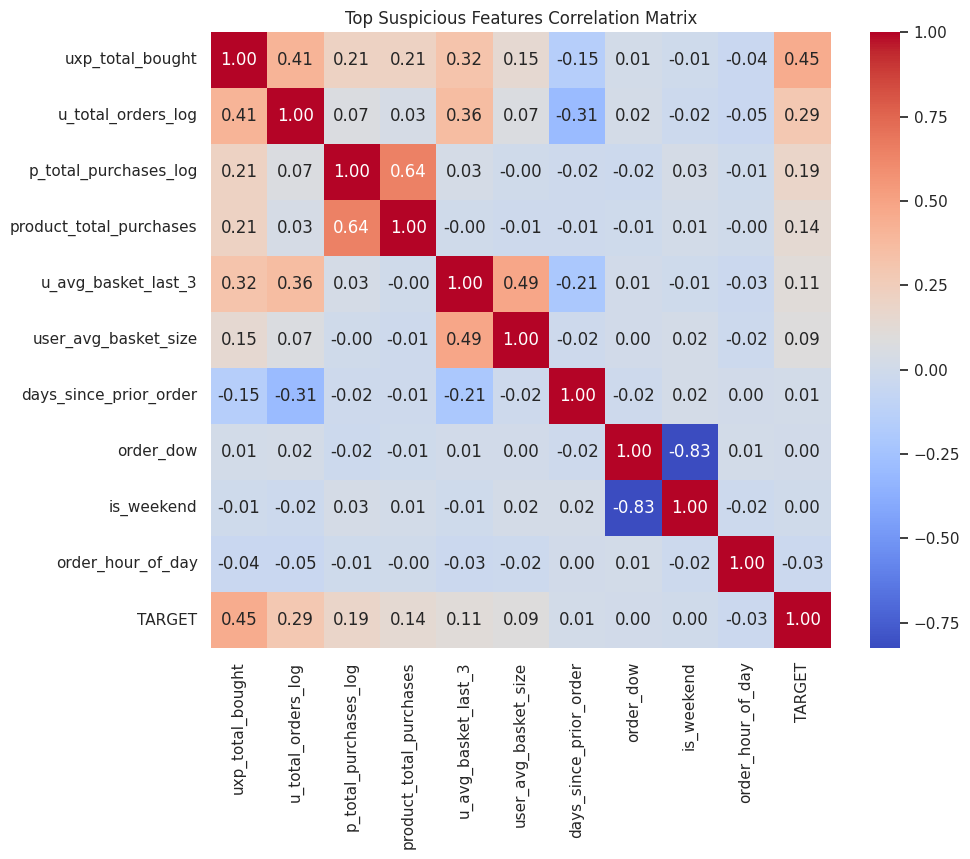

In [ ]:
كود لتتحقق من الداتا ليكيج وفحص الفبتشرز الي بالتريننق
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# print("🔍 Starting Feature Forensic Analysis...")

# # 1. تجميع الداتا مؤقتاً عشان الفحص
# # بناخذ نسخة عشان ما نخرب الداتا الأصلية
# inspection_df = xc_train.copy()
# inspection_df['TARGET'] = yc_train  # بنضيف الجواب عشان نقارن معه

# # 2. طباعة كل الأعمدة الموجودة
# print("\n📋 List of All Features used in Training:")
# print("-" * 40)
# cols = xc_train.columns.tolist()
# for i, col in enumerate(cols):
#     print(f"{i+1}. {col}")

# # 3. حساب الكورليشن مع التارجت (فحص الغش)
# print("\n📊 Correlation with TARGET (Suspicion Level):")
# print("-" * 40)

# # بنحسب الارتباط بس للأعمدة الرقمية عشان ما يضرب إيرور
# numeric_corr = inspection_df.corr(numeric_only=True)['TARGET'].sort_values(ascending=False)

# # بنشيل التارجت نفسه من القائمة عشان ما يشوش علينا
# numeric_corr = numeric_corr.drop('TARGET', errors='ignore')

# # عرض أعلى 10 أعمدة ارتباطاً (هدول اللي عليهم العين)
# print(numeric_corr.head(10))

# print("\n📉 Lowest 5 columns (Negative Correlation):")
# print(numeric_corr.tail(5))

# # 4. رسمة توضيحية (Heatmap) لأعلى 10 أعمدة
# # عشان تشوف بعينك مين "منور" زيادة عن اللزوم
# top_features = numeric_corr.head(10).index.tolist()
# if len(top_features) > 0:
#     plt.figure(figsize=(10, 8))
#     # بنضيف التارجت عشان نشوف علاقته فيهم
#     top_features.append('TARGET')
#     sns.heatmap(inspection_df[top_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
#     plt.title("Top Suspicious Features Correlation Matrix")
#     plt.show()
# else:
#     print("No numeric features found to plot.")

In [ ]:
available_users = xc_train["user_id"].unique()
n_users = len(available_users)
n_users

4000

In [ ]:
#اصريت اتأكد انه الترانسفورم تطبق
print(train_cls.shape)
print(xc_train.shape)
print()
preprocessor.get_feature_names_out()

(541425, 42)
(541425, 19)



array(['encoding__department_id_2', 'encoding__department_id_3',
       'encoding__department_id_4', 'encoding__department_id_5',
       'encoding__department_id_6', 'encoding__department_id_7',
       'encoding__department_id_8', 'encoding__department_id_9',
       'encoding__department_id_10', 'encoding__department_id_11',
       'encoding__department_id_12', 'encoding__department_id_13',
       'encoding__department_id_14', 'encoding__department_id_15',
       'encoding__department_id_16', 'encoding__department_id_17',
       'encoding__department_id_18', 'encoding__department_id_19',
       'encoding__department_id_20', 'encoding__department_id_21',
       'encoding__order_dow_1', 'encoding__order_dow_2',
       'encoding__order_dow_3', 'encoding__order_dow_4',
       'encoding__order_dow_5', 'encoding__order_dow_6',
       'encoding__time_of_day_Evening', 'encoding__time_of_day_Midnight',
       'encoding__time_of_day_Morning', 'target_encoding__user_id',
       'target_encoding__

reordered
1    0.572971
0    0.427029
Name: proportion, dtype: float64


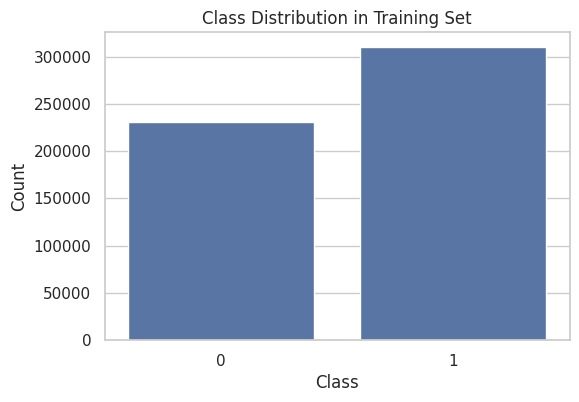

In [ ]:
print(yc_train.value_counts(normalize=True))

plt.figure(figsize=(6 , 4))
sns.countplot(x=yc_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#هيك بين عندي انه في تفاوت بنسب الكلاسين اللي عندي , الفرق ما بأثر كثير بس لازم اعمل موازنه لانه الدكتور طلب

In [ ]:
'''smote = SMOTE(random_state=42)
smote_xtrain, smote_ytrain = smote.fit_resample(train_cls, yc_train)      #بتعمل KNN
#اللي بصير هون انه السموت رح تزيد قيم الكلاس القليل بقيم ثناعيه او وهميه عشان التوازن
print(smote_ytrain.value_counts())

print("----------------------------------------------------------------")
# # '''
# rus = RandomUnderSampler(random_state = 42)
#   under_xtrain , under_ytrain = rus.fit_resample(train_cls , yc_train)
#   #هاي بتحذف من الكلاس الكبير بطريقه يصير قريب للكلاس الاقل , فيها مشكله انه ممكن تخسر بيانات مهمه من وراها واصلا هيك هيك الدقه فيها مش احسن اشي ف ما رح نستخدمها
#   print(under_ytrain.value_counts())

'smote = SMOTE(random_state=42)\nsmote_xtrain, smote_ytrain = smote.fit_resample(train_cls, yc_train)      #بتعمل KNN\n#اللي بصير هون انه السموت رح تزيد قيم الكلاس القليل بقيم ثناعيه او وهميه عشان التوازن\nprint(smote_ytrain.value_counts())\n\nprint("----------------------------------------------------------------")\n# # '

In [ ]:
model_original = RandomForestClassifier(n_estimators = 50 , max_depth = 20 , class_weight = "balanced")
#class_weight = 'balanced' هاي بتعطي اهميه اكبر للكلاس الاقل , يعني بتعاقب الموديل لما يهمله ف مجازيا بزيد وزنه , تعتبر بديل لكلشي عملناه تحت
#بدونها رح يكون في تحييز للكلاس اللي حجمه اكبر , وليش ؟ لانه الموديل بفهم انه هاض الكلاس لانه اكبر معناها هاض مهم والثاني لا
model_original.fit(train_cls , yc_train)

pred_O = model_original.predict(test_cls)
print(classification_report(yc_test , pred_O))
print(model_original.score(test_cls , yc_test))

print("----------------------------------------------------------------")

# model_smote = RandomForestClassifier(n_estimators = 50 , max_depth = 20)
# model_smote.fit(smote_xtrain , smote_ytrain)

# pred_S = model_smote.predict(test_cls)
# print(classification_report(yc_test , pred_S))
# print(model_smote.score(test_cls , yc_test))

# #السكور زاد بنسبه خفيفه , استدعاء الفئه اللي كانت اقل تحسن , الدقه قلت بنسبة خفيفه والسبب انه بطل يعتمد على كلاس واحد صار يعتمد على ثنين بالتصنيف ف نسبة الدقه اقل هون


# print("----------------------------------------------------------------")

# model_under = RandomForestClassifier(n_estimators = 50 , max_depth = 20 , random_state = 42)
# model_under.fit(under_xtrain , under_ytrain)

# pred_U = model_under.predict(test_cls)
# print(classification_report(yc_test , pred_U))
# print(model_under.score(test_cls , yc_test))

              precision    recall  f1-score   support

           0       0.67      0.97      0.79     23041
           1       0.98      0.80      0.88     55245

    accuracy                           0.85     78286
   macro avg       0.83      0.88      0.84     78286
weighted avg       0.89      0.85      0.86     78286

0.8499093069003398
----------------------------------------------------------------


In [ ]:
'''fig, axes = plt.subplots(1, 3, figsize=(20, 5))

models_list = [
    (model_original, "Original (Class Weights)"),
    (model_smote, "SMOTE"),
    (model_under, "UnderSampling")
]

for i, (model, title) in enumerate(models_list):
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        test_cls,
        yc_test,
        display_labels=['Not Reordered', 'Reordered'],
        cmap=plt.cm.Blues,
        normalize='true',
        ax=axes[i]
    )
    axes[i].set_title(title)

plt.tight_layout()
plt.show()
'''
#اول مره جربت اشغل هذول عالبيانات قبل التوزيع حسب الزمن , كان تقسيم عشوائي , وطلع معي انع الالفضل سموت , بس بعد التقسيم حسب الزمن رح نعتمد الداتا الاصليه
## رجعت جربت بيانات اكبر وطلع معي السموت اعلى بنسبه بسيييييييطه وعشان هيك مش رح اهتم بالنسبه هاي ورح اعتمد الداتا الاصليه لانها ما بتوخذ وقت عكس السموت

'fig, axes = plt.subplots(1, 3, figsize=(20, 5))\n\nmodels_list = [\n    (model_original, "Original (Class Weights)"),\n    (model_smote, "SMOTE"),\n    (model_under, "UnderSampling")\n]\n\nfor i, (model, title) in enumerate(models_list):\n    disp = ConfusionMatrixDisplay.from_estimator(\n        model,\n        test_cls,\n        yc_test,\n        display_labels=[\'Not Reordered\', \'Reordered\'],\n        cmap=plt.cm.Blues,\n        normalize=\'true\',\n        ax=axes[i]\n    )\n    axes[i].set_title(title)\n\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np

# print("🕵️‍♂️ Starting Data Leakage Investigation...")

# # 1. دمج الداتا مع التارجت عشان الفحص
# # افترض ان xc_train هي الداتا و yc_train هو التارجت
# check_df = xc_train.copy()
# check_df['target'] = yc_train.values

# # الأعمدة المشكوك فيها (اللي رجعناها جديد)
# suspect_features = ['uxp_total_bought', 'uxp_reorder_ratio']
# # تأكد إن الأسماء مطابقة للي عندك، ضيف أي عمود uxp آخر هنا

# # --- الاختبار الأول: مصفوفة الارتباط (Correlation Matrix) ---
# # إذا الارتباط كان 1.0 أو قريب جداً (فوق 0.95)، فهذا جرس إنذار!
# print("\n📊 1. Correlation Check:")
# corr_matrix = check_df[suspect_features + ['target']].corr()
# print(corr_matrix['target'])

# plt.figure(figsize=(6, 4))
# sns.heatmap(corr_matrix[['target']].sort_values(by='target', ascending=False),
#             annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title("Correlation with Target (Red Flag if > 0.9)")
# plt.show()

# # --- الاختبار الثاني: هل الفصل مثالي زيادة عن اللزوم؟ (Boxplot) ---
# # إذا شفت الصناديق بعيدة عن بعض تماماً وما في تداخل، معناها المودل "شايف" الجواب.
# print("\n📦 2. Separation Check (Boxplots):")
# fig, axes = plt.subplots(1, len(suspect_features), figsize=(12, 5))

# for i, col in enumerate(suspect_features):
#     if col in check_df.columns:
#         sns.boxplot(x='target', y=col, data=check_df, ax=axes[i])
#         axes[i].set_title(f'{col} vs Target')
#         axes[i].grid(True, alpha=0.3)
#     else:
#         print(f"⚠️ Column {col} not found in DataFrame")

# plt.tight_layout()
# plt.show()

# # --- الاختبار الثالث: المنطق (Logic Check) ---
# # هذا الكود بيفحص إذا في حالة مستحيلة
# # مثلاً: هل يعقل أن يكون الـ Ratio = 1 دائماً لما التارجت = 1؟
# if 'uxp_reorder_ratio' in check_df.columns:
#     suspicious_perfect_ratio = check_df[(check_df['target'] == 1) & (check_df['uxp_reorder_ratio'] == 1.0)]
#     total_positives = check_df[check_df['target'] == 1]

#     print("\n🧮 3. Logic Check (Ratio Analysis):")
#     print(f"Total Positive Cases (Ordered): {len(total_positives)}")
#     print(f"Cases with Perfect Ratio (1.0) among Positives: {len(suspicious_perfect_ratio)}")

#     ratio_percentage = len(suspicious_perfect_ratio) / len(total_positives) * 100
#     print(f"Percentage of perfect ratios: {ratio_percentage:.2f}%")

#     if ratio_percentage > 90:
#         print("🚨 DANGER: More than 90% of reordered items have a PERFECT ratio. High chance of LEAKAGE!")
#     else:
#         print("✅ SAFE: The ratio varies normally. Probably no leakage.")

🕵️‍♂️ Starting Data Leakage Investigation...

📊 1. Correlation Check:


KeyError: "['uxp_reorder_ratio'] not in index"

رح نعتمد هذول بالتدريب train_cls , yc_train

وهذول بالاختبار test_cls , yc_test

Task A

Support Vector Machine

In [ ]:
np.random.seed(42)
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=40, replace=False)
#قللنا السايز كثير عشان المودل هاض خصيصا بطيئ بالداتا الكبيره لانو بحتاج يحسب المسافه
#بين كل نقطه وباقي النقاط فلو كانت مثلا 20 الف رح تضربها كمان ب 20 الف بطلع عندك 400 الف عمليه حسابيه
# وهاص الحكي على مره تدريب وحده يعني عشان نعمل قريد سيرش بدنا ندرب قول 3 مرات مثلا رح ال 400 الف بثلاث فا بتفقع الامور عشان هيك لازم السايز قليل
SVC_x_small = xc_train[xc_train['user_id'].isin(tuning_users_ids)].copy().sort_values(by=['user_id'])
SVC_y_small = yc_train.loc[SVC_x_small.index]

print(f"Tuning Sample Size: {SVC_x_small.shape}")


Tuning Sample Size: (5158, 19)


In [ ]:

SVC_pipeline = make_pipeline(  preprocessor, SVC(class_weight='balanced', random_state=42, cache_size=1000)
)
SVC_param_grid = {
    "svc__C": [0.1, 1, 10],

    "svc__kernel": ['linear', 'rbf'],

    # Gamma: (بس للـ rbf) قديش النقطة بتأثر عاللي حولها
    "svc__gamma": ['scale', 'auto']
}

# 3. إعداد الجريد سيرش (الحكم)
SVC_grid_search = GridSearchCV(
    estimator = SVC_pipeline,
    param_grid = SVC_param_grid,
    cv = 3,
    scoring = "f1",
    n_jobs = -1,
    verbose = 1
)




SVC_grid_search.fit(SVC_x_small, SVC_y_small)


print("Best Score (F1):", SVC_grid_search.best_score_)
print("Best Parameters:", SVC_grid_search.best_params_)
#كان السايز 40 وكان معطيني سكور 69 قلت لو زدت السايز ممكن يزيد لكنه نزل لما زدته هاض بكون بسبب ممكن انو الي زدتهم فيهم نويز اكثر فا عشان هيك
#بس ال مهم انو المودل اختار نفس البارميترز في الحالين فا هاض دليل انه هذول همه الاوبتمال او المناسبين للداتا تبعتنا

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Score (F1): 0.7724557856423883
Best Parameters: {'svc__C': 1, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}


In [ ]:
# هون اول مره عملت البايب لاين على الترين كامل والي هي 500 الف فا الجهاز ماستحمل
# # وطول كثير كثير وممكن مايخلص فا الحل هو انك توخذ برضو عينه صغيره من الترين حتى يقدر يستوعبها الجهاز
training_indices = np.random.choice(xc_train.index, size=30000, replace=False)


xc_train_small = xc_train.loc[training_indices].copy()
yc_train_small = yc_train.loc[training_indices].copy()

print(f" Training Data Downsampled : {xc_train_small.shape}")

best_params = SVC_grid_search.best_params_


final_SVC_pipeline = make_pipeline(
    preprocessor,
    SVC(
        C = best_params['svc__C'],
        kernel = best_params['svc__kernel'],
        gamma = best_params['svc__gamma'],
        class_weight = 'balanced',
        random_state = 42,
        cache_size = 2000,
        verbose = True
    )
)

final_SVC_pipeline.fit(xc_train_small, yc_train_small)
# # optimization finished, #iter = 24601
# obj = -1859.055235, rho = -0.803259
# nSV = 21295, nBSV = 14710
# Total nSV = 21295
#هاض الحكي الي بهمني منو انو اول اشي المودل احتاج 24 الف اتريشن على داتا زي هيك فهو رقم كويس تمام
#ثاني اشي بهمني هو ال nSV
#هو عباره عن عدد النقاط الي اعتبرهم المودل سبورت فيكتور مشين طب ليش طلعو هيك لانو الكومبليكستي واطيه
#ال c طلعت 0.1
#عشان هيك المارجن كبير فا اخذ اكثر من سبورت فيكتور لانو المودل سمبل

 Training Data Downsampled : (30000, 19)
[LibSVM]...............*..*.*
optimization finished, #iter = 17601
obj = -10738.284920, rho = -2.526212
nSV = 11939, nBSV = 9359
Total nSV = 11939


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('encoding',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['department_id', 'order_dow',
                                                   'time_of_day']),
                                                 ('target_encoding',
                                                  TargetEncoder(smoothing=50),
                                                  ['user_id', 'product_id',
                                                   'aisle_id']),
                                                 ('Frequency',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               normalize=True),
                                                  'product_name'),
                                                 ('scaling', StandardScaler(),
                                                  ['days_since_prior_order',
                                                   'is_weekend',
                                                   'user_avg_days_between',
                                                   'user_avg_basket_size',
                                                   'u_total_orders_log',
                                                   'product_total_purchases',
                                                   'p_total_purchases_log',
                                                   'uxp_total_bought',
                                                   'u_avg_basket_last_3'])])),
                ('svc',
                 SVC(C=1, cache_size=2000, class_weight='balanced',
                     gamma='auto', random_state=42, verbose=True))])

In [ ]:
y_pred_svc = final_SVC_pipeline.predict(xc_test)

print(classification_report(yc_test, y_pred_svc))
# النتائج الي طلعت رائعه
#               precision    recall  f1-score   support

#            0       0.51      0.65      0.57     23041
#            1       0.83      0.74      0.78     55245

#     accuracy                           0.71     78286
#    macro avg       0.67      0.69      0.68     78286
# weighted avg       0.74      0.71      0.72     78286


#=====================================
#بعد اضافه تو كولمز مهمين والتاكد انو مافي داتا لليكيج
#      precision    recall  f1-score   support

#            0       0.78      0.95      0.86     23041
#            1       0.98      0.89      0.93     55245

#     accuracy                           0.91     78286
#    macro avg       0.88      0.92      0.89     78286
# weighted avg       0.92      0.91      0.91     78286


              precision    recall  f1-score   support

           0       0.58      0.90      0.70     23041
           1       0.94      0.72      0.82     55245

    accuracy                           0.78     78286
   macro avg       0.76      0.81      0.76     78286
weighted avg       0.84      0.78      0.79     78286



In [ ]:
# تجهيز الـ Scores عشان نستخدمهم في الرسمات الجاية
# الـ decision_function بتعطينا رقم بيعبر عن "بعد النقطة عن الخط الفاصل"
# كل ما كان الرقم أكبر، كان المودل متأكد أكثر إنه Class 1
# y_score = final_SVC_pipeline.decision_function(xc_test)
# هاي الدالة بتعطيك المسافة والاتجاه بالضبط عن الخط
#لانو هاي الرسمات بتحتاج لارقام كنتونويس سكور مش ماببزبط معها 0 و 1


In [ ]:
#  Confusion Matrix Raw & Normalized
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# #Raw
# ConfusionMatrixDisplay.from_predictions(
#     yc_test, y_pred_svc,
#     display_labels=['Not Reordered', 'Reordered'],
#     cmap='Blues', ax=axes[0], colorbar=False
# )
# axes[0].set_title("Confusion Matrix (Raw Counts)")

# # Normalized
# ConfusionMatrixDisplay.from_predictions(
#     yc_test, y_pred_svc,
#     display_labels=['Not Reordered', 'Reordered'],
#     cmap='Greens', normalize='true', ax=axes[1], colorbar=False
# )
# axes[1].set_title("Confusion Matrix (Normalized %)")

# plt.show()

#المربع الفوق اليسار بعبر عن عدد الناس الي ماشترت والمودل فعلا قال عنهم ما اشترو تمام يعني حسب الرسمتين عنا 65 بالميه جابهم صح
#المربع الي فوق عاليمين هذول الي ما اشترو بس المودل تحمس وقال انهم رح يشترو يعني هون غلط ب 35 بالميه
#اذا الي المربعات الي فوق بتعبر عن الي ما اشترو
#===========================================
 # المربع الي تحت يسار بتعبر عن الناس الي اشترو فعلا بس المودل قال عنهم ما اشترو
# المربع الي تحت يمين بعبر عن الي اشترو وفهلا المودل توقع انهم رح يشترو حققنا True Positive Rate بنسبة 74%
#==================================================================
# الخلاصه
# فوق - يسار True Negative
# فوق - يمين False Positive
# تحت - يسار False Negative
# تحت - يمين True Positive 74% 40900

In [ ]:
# المودل ممتاز جداً في تحديد من سيقوم بالشراء حيث جبنا 74 بالميه من الناس الي اشترو
# لاكن المودل ضيع 26 بالميه من الناس الي اشترت

In [ ]:
#  ROC Curve + AUC
# plt.figure(figsize=(8, 6))

# # بنستخدم y_score اللي جهزناها فوق
# RocCurveDisplay.from_predictions(
#     yc_test, y_score,
#     name="SVM (RBF)",
#     color="orange"
# )

# #  هون بنرسم خط الحظ الصدفة عشان نقارن فيه
# plt.plot([0, 1], [0, 1], "k--", label="Chance Level (AUC = 0.5)")
# plt.title("ROC Curve")
# plt.grid(True, alpha=0.3)
# plt.legend()
# plt.show()
# الخط البرتقالي SVM RBF
#ما إنه مقوس لفوق جهة اليسار فهذا دليل ممتاز
# الخط البرتقالي يببتعد بوضوح عن خط الصدفة Chance Level
# هاض دليل انو المودل تعلم انماط حقيقيه

In [ ]:
# : Precision-Recall Curve
# plt.figure(figsize=(8, 6))

# PrecisionRecallDisplay.from_predictions(
#     yc_test, y_score,
#     name="SVM (RBF)",
#     plot_chance_level=True,
#     color="purple"
# )

# plt.title("Precision-Recall Curve ")
# plt.grid(True, alpha=0.3)
# plt.legend(loc="best")
# plt.show()
# # بالنسبة لـ Precision-Recall Curve
# هاي الرسمه افضل من الي قبلها لانها بتعطيك كلشي بوضوح
#  هاي هي الرسمه المهمه لللتعامل مع الداتا الي مش متوازنه او الان بلانسد تمام هون بنشوف انو خط الصدفه عالي 0.71 وهاض بيعني فعلا انو الداتا مش متوازنه
# الان المودل المنيح هو الي بقدر يعلي ال AP
# هي بتعبتر عن الافريح اوف بيرسجن يعني معدل الدقه تمام واحنا عليها فوقيه حيث طلع معنا 0.87


In [ ]:


# Cell: Professional Decision Boundary Visualization ---
# print("🎨 Generating Professional Decision Boundary Plots...")

# # 1. اختيار الأعمدة الممتازة (Continuous Features)
# col_x = 'user_avg_basket_size'    # متوسط حجم السلة
# col_y = 'user_avg_days_between'   # معدل الأيام بين الطلبات

# # التأكد من وجود الأعمدة (احتياط)
# if col_x in xc_train.columns and col_y in xc_train.columns:
#     print(f"✅ Found features: {col_x} vs {col_y}")
#     X_vis = xc_train[[col_x, col_y]].values
#     y_vis = yc_train.values
# else:
#     print("⚠️ Columns not found, falling back to indices.")
#     X_vis = xc_train.iloc[:, [13, 12]].values # تقديراً لمواقعهم
#     y_vis = yc_train.values

# # 2. أخذ عينة (500 نقطة)
# np.random.seed(42)
# idx = np.random.choice(np.arange(len(X_vis)), size=500, replace=False)
# X_vis_small = X_vis[idx]
# y_vis_small = y_vis[idx]

# # 3. Scaling (مهم جداً جداً هنا)
# scaler_vis = StandardScaler()
# X_vis_small = scaler_vis.fit_transform(X_vis_small)

# # 4. تدريب الموديلات
# models = (
#     SVC(kernel="linear", C=1.0),
#     SVC(kernel="rbf", C=1.0, gamma='auto')
# )
# models = [clf.fit(X_vis_small, y_vis_small) for clf in models]

# # 5. الرسم
# titles = (f"Linear SVM\n({col_x} vs {col_y})", f"RBF SVM\n({col_x} vs {col_y})")
# fig, sub = plt.subplots(1, 2, figsize=(14, 6))
# plt.subplots_adjust(wspace=0.2, hspace=0.2)

# X0, X1 = X_vis_small[:, 0], X_vis_small[:, 1]
# # زيادة دقة الشبكة (Resolution) عشان المنحنيات تكون ناعمة
# xx, yy = np.meshgrid(np.arange(X0.min()-0.5, X0.max()+0.5, 0.02),
#                      np.arange(X1.min()-0.5, X1.max()+0.5, 0.02))

# for clf, title, ax in zip(models, titles, sub.flatten()):
#     Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
#     Z = Z.reshape(xx.shape)

#     # الرسم بالألوان (Contours)
#     ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
#     # رسم النقاط (Scatter)
#     ax.scatter(X0, X1, c=y_vis_small, cmap=plt.cm.coolwarm, s=35, edgecolors="k", alpha=0.9)

#     ax.set_title(title, fontsize=12, fontweight='bold')
#     ax.set_xlabel("User Avg Basket Size (Standardized)")
#     ax.set_ylabel("User Avg Days Between (Standardized)")

# plt.show()

In [ ]:
# خليه برجعله مش فاهمه منيح
# شرح الرسم بياني (Interpretation):
# ---------------------------------------------------------
# هذه الرسمة توضح لماذا يتفوق مودل الـ (RBF SVM) على المودل الخطي (Linear SVM) في هذه البيانات:

# 1. المحاور (Axes):
#    - المحور العمودي (Y): يمثل "معدل الأيام بين الطلبات" (كل ما كنا تحت، يعني الزبون بيطلب بسرعة أكبر).
#    - المحور الأفقي (X): يمثل "متوسط حجم السلة".

# 2. المودل الخطي (Linear SVM - اليسار):
#    - يحاول الفصل بين الفئات بخط مستقيم (Straight Line).
#    - نلاحظ أنه فشل في عزل النقاط الحمراء (الزبائن الذين أعادوا الشراء) بدقة، لأن سلوكهم متداخل ولا يتبع خطاً مستقيماً.

# 3. مودل الـ (RBF SVM - اليمين):
#    - استخدم حدوداً منحنية ومرنة (Non-Linear Boundary).
#    - نجح بذكاء في تحديد "منطقة الولاء" (في الأسفل)، حيث اكتشف أن الزبائن الذين يطلبون بفترات متقاربة (Low Days Between) هم الأكثر ترجيحاً لإعادة الشراء، وقام بعزلهم بدقة عالية.

# الخلاصة: هذا يثبت بصرياً أن العلاقة في البيانات غير خطية (Non-Linear)، مما يجعل الـ RBF الخيار الأمثل.


In [ ]:
# ضل هون نضيف نويز ونعملو تيست


Gradient boosting classifier

In [ ]:
# رح نسخدم هالمره الترين سي ل س عشان معمولها بري بروسس وكلها ارقام لانو لو استخدمنا الداتا العاديه رح نتطر نحذ الكولومز الي مش رقميه وبالتالي نخسر بيانات مهمه
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=1000, replace=False)


# بما أن train_cls يطابق xc_train سطراً بسطر، نستخدم شرط xc_train لقص train_cls
XGB_x_small = train_cls[xc_train['user_id'].isin(tuning_users_ids)]
XGB_y_small = yc_train[xc_train['user_id'].isin(tuning_users_ids)]

ratio = float(np.sum(XGB_y_small == 0)) / np.sum(XGB_y_small == 1)

print(f"Tuning shape: {XGB_x_small.shape}")
print(f"Calculated Ratio: {ratio:.2f}")

Tuning shape: (130745, 42)
Calculated Ratio: 0.75


In [ ]:
 # تعريف الموديل مباشرة بدون Pipeline لأن الداتا جاهزة
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=ratio,
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

XGBparam_grid = {
    "learning_rate": [0.01, 0.1, 0.2],
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7]
}


XGB_grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = XGBparam_grid,
    cv = 3,
    scoring = "f1",
    n_jobs = -1,

)


XGB_grid_search.fit(XGB_x_small, XGB_y_small)

print("\nBest Score (F1):", XGB_grid_search.best_score_)
print("Best Parameters:", XGB_grid_search.best_params_)
# بعد التعديل ارتفعت السكور من 72 ل 77
# Best Score (F1): 0.7726193292101673
# Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:41:25] WARNING: /w


Best Score (F1): 0.8736576164658553
Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


In [ ]:
best_LR = XGB_grid_search.best_params_["learning_rate"]
best_NE = XGB_grid_search.best_params_["n_estimators"]
best_MD = XGB_grid_search.best_params_["max_depth"]

# print(f"Learning Rate: {best_LR}, N_Estimators: {best_NE}, Max_Depth: {best_MD}")

In [ ]:
full_ratio = float(np.sum(yc_train == 0)) / np.sum(yc_train == 1)
print(f"Full Data Ratio: {full_ratio:.2f}")


#  #  الموديل النهائي
# final_xgb = XGBClassifier(
#     learning_rate = best_LR,
#     n_estimators = best_NE,
#     max_depth = best_MD,
#     scale_pos_weight = full_ratio,
#     objective = 'binary:logistic',
#     eval_metric = 'logloss',
#     use_label_encoder = False,
#     random_state = 42,
#     n_jobs=-1
# )

# # على كل الداتا
# final_xgb.fit(train_cls, yc_train)


#========================================================
# عشان نعمل خظوه الايرلي سبلتنق لازم نقسم الداتا كمان مره ولازم ننتبه يكون تقسيمنا براعي الزمن الي قسمناه بالبدايه تمام
#لانو الايرلي ستوبنق بحتاج نعمل فاليديشن اكثر من مره حتى يعرف متى يوقف
# بنجيب كل اليوزرز من الداتا الأصلية وبنقسمهم 90% تدريب 10% مراقبة
train_users, val_users = train_test_split(xc_train['user_id'].unique(), test_size=0.10, random_state=42)

# 2. عمل الماسك (Masks) لتحديد أماكن هدول اليوزرز في الداتا
# train_mask: بيحدد أسطر يوزرز التدريب
# val_mask: بيحدد أسطر يوزرز المراقبة
train_mask = xc_train['user_id'].isin(train_users).values
val_mask = xc_train['user_id'].isin(val_users).values

# 3. تطبيق الماسك على الداتا المعالجة الجاهزة (train_cls)
# هيك ضمنا إن X_tr و X_val مفصولين تماماً بناءً على الأشخاص
X_tr = train_cls[train_mask]
y_tr = yc_train[train_mask]

X_val = train_cls[val_mask]
y_val = yc_train[val_mask]

print(f"Train shapes: {X_tr.shape}, Val shapes: {X_val.shape}")


final_xgb = xgb.XGBClassifier(
    learning_rate = best_LR,
    n_estimators = 3000,         # رقم كبير جدا نعطيه راحته
    max_depth = best_MD,
    # scale_pos_weight = full_ratio,
    objective = 'binary:logistic',
    eval_metric = 'logloss',
    use_label_encoder = False,
    early_stopping_rounds = 50,  #وقف اذا ماتحسن بعد 50 راوند
    random_state = 42,
    n_jobs = -1
)

final_xgb.fit(
    X_tr, y_tr,
    eval_set=[(X_tr, y_tr), (X_val, y_val)],
    verbose=False
)

print("-" * 30)
print(f"Training Stopped at iteration: {final_xgb.best_iteration}")
print(f"Best Validation Score: {final_xgb.best_score}")


Full Data Ratio: 0.75
Train shapes: (486182, 42), Val shapes: (55243, 42)


/usr/local/lib/python3.12/dist-packages/xgboost/callback.py:386: UserWarning: [23:42:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  self.starting_round = model.num_boosted_rounds()


------------------------------
Training Stopped at iteration: 74
Best Validation Score: 0.3090300727085287


In [ ]:
y_pred_xgb = final_xgb.predict(test_cls)

print(" XGBoost Report")
print(classification_report(yc_test, y_pred_xgb))

print(f"XGBoost Accuracy: {final_xgb.score(test_cls, yc_test)}")
# هاي النتائج قبل الايرلي ستوبنق
# XGBoost Report
#               precision    recall  f1-score   support

#            0       0.50      0.71      0.59     23041
#            1       0.85      0.70      0.77     55245

#     accuracy                           0.70     78286
#    macro avg       0.67      0.71      0.68     78286
# weighted avg       0.75      0.70      0.71     78286

# XGBoost Accuracy: 0.702922617070740

# النتائج هاي بعد الايرلي ستوبنق وفرقت معنا منيح
# XGBoost Report
#               precision    recall  f1-score   support

#            0       0.51      0.74      0.60     23041
#            1       0.87      0.70      0.77     55245

#     accuracy                           0.71     78286
#    macro avg       0.69      0.72      0.69     78286
# weighted avg       0.76      0.71      0.72     78286

# XGBoost Accuracy: 0.7107784278159569
#بنلاحظ الاكيروسي زادت تقريبا 1 بالميه
# وال ري كول لكلاس 0 تحسن بشكل منيح من 71 ل 74 يعني المودل صار احسن بالي مابشترو
#======================================


# بعد اضافه تو كولمز مهمين

#  XGBoost Report
#               precision    recall  f1-score   support

#            0       0.75      0.97      0.85     23041
#            1       0.98      0.87      0.92     55245

#     accuracy                           0.90     78286
#    macro avg       0.87      0.92      0.88     78286
# weighted avg       0.92      0.90      0.90     78286


 XGBoost Report
              precision    recall  f1-score   support

           0       0.75      0.97      0.84     23041
           1       0.98      0.86      0.92     55245

    accuracy                           0.89     78286
   macro avg       0.87      0.92      0.88     78286
weighted avg       0.91      0.89      0.90     78286

XGBoost Accuracy: 0.8945022098459494


In [ ]:

# import matplotlib.pyplot as plt
# import xgboost as xgb

print("📊 Plotting Feature Importance...")

try:
    # 1. محاولة جلب أسماء الأعمدة الحقيقية من الـ preprocessor
    # (عشان نعرف شو اللي بيأثر عالشراء بالضبط)
    feature_names = preprocessor.get_feature_names_out()

    # تنظيف الأسماء (حذف الزوائد زي 'cat__', 'num__' الخ)
    clean_names = [name.split('__')[-1] for name in feature_names]

    # ربط الأسماء بالمودل
    final_xgb.get_booster().feature_names = clean_names

    # 2. الرسم مع الأسماء
    fig, ax = plt.subplots(figsize=(12, 10))
    xgb.plot_importance(
        final_xgb,
        ax=ax,
        max_num_features=20,     # عرض أهم 20 عامل فقط
        height=0.5,
        importance_type='weight', # عدد مرات استخدام العمود في الشجر
        color='teal',
        title="Top 20 Features Influencing Reorders (XGBoost)"
    )
    plt.show()

except Exception as e:
    print(f"Could not extract feature names automatically (Error: {e}). Plotting by index instead...")

    # 3. الرسم الاحتياطي (بالأرقام) لو فشل سحب الأسماء
    fig, ax = plt.subplots(figsize=(10, 8))
    xgb.plot_importance(final_xgb, ax=ax, max_num_features=20, height=0.5, color='teal')
    plt.title("Top 20 Features (by Index)")
    plt.show()

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# منغير النوع لـ 'gain' عشان نشوف الجودة مش العدد
plt.figure(figsize=(12, 10))
plot_importance(final_xgb, max_num_features=20, importance_type='gain', height=0.5, title='Feature Importance (by Gain)')
plt.show()

Decision Tree classifier


In [ ]:
from sklearn.tree import DecisionTreeClassifier
np.random.seed(42)
tuning_users_ids = np.random.choice(xc_train['user_id'].unique(), size=2500, replace=False)
# سحب الداتا تاعت هذول  اليوزرز
DT_x_small = xc_train[xc_train['user_id'].isin(tuning_users_ids)].copy().sort_values(by=['user_id'])
DT_y_small = yc_train.loc[DT_x_small.index]
print(f"Sample Size for Tuning: {DT_x_small.shape}")

Sample Size for Tuning: (342608, 19)


In [ ]:


# 1. دمج المعالج (preprocessor) مع المودل (DecisionTree) في خطوة واحدة
DT_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(class_weight='balanced', random_state=42)
)

# 2. تجهيز قائمة الاحتمالات اللي بدنا نجربها
# ملاحظة: لازم نكتب اسم المودل (decisiontreeclassifier) بعدين شرطتين (__) قبل اسم الباراميتر
DT_param_grid = {
    "decisiontreeclassifier__max_depth": [10, 15, 20, None],      # جرب هدول الأعماق
    "decisiontreeclassifier__min_samples_leaf": [20, 50, 100],    # جرب هدول الأعداد للأوراق
    "decisiontreeclassifier__criterion": ["gini", "entropy"]      # جرب المعادلتين
}

# 3. إعداد أداة البحث (GridSearchCV)
DT_grid_search = GridSearchCV(
    estimator = DT_pipeline,   # البايبلاين اللي عملناه
    param_grid = DT_param_grid,# الاحتمالات اللي فوق
    cv = 3,                    # قسم العينة لـ 3 أجزاء للتأكد (Cross Validation)
    scoring = "f1",            # أهم مقياس عنا هو F1 للكلاس 1
    n_jobs = -1,               # شغل كل أنوية المعالج عشان السرعة
    verbose = 1                # طلعلي كلام عالشاشة وأنت بتشتغل
)

In [ ]:
print("Running GridSearchCV on Small Sample...")

# تدريب البحث على العينة الصغيرة فقط للسرعة
DT_grid_search.fit(DT_x_small, DT_y_small)

print("\n Tuning Done")
print("Best Score (F1):", DT_grid_search.best_score_)
print("Best Parameters:", DT_grid_search.best_params_)

Running GridSearchCV on Small Sample...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Tuning Done
Best Score (F1): 0.8717405670613078
Best Parameters: {'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 10, 'decisiontreeclassifier__min_samples_leaf': 100}


In [ ]:
print("\n3️⃣ Training Final Decision Tree Model on FULL Data...")

# 1. استخراج أفضل القيم الفائزة
best_params = DT_grid_search.best_params_

# 2. بناء المودل النهائي بهذه القيم
final_DT_pipeline = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(
        criterion = best_params['decisiontreeclassifier__criterion'],
        max_depth = best_params['decisiontreeclassifier__max_depth'],
        min_samples_leaf = best_params['decisiontreeclassifier__min_samples_leaf'],
        class_weight = 'balanced',
        random_state = 42
    )
)

# 3. التدريب على الداتا الكاملة (xc_train)
# لاحظ: استخدمنا xc_train لأن البايبلاين يبدأ بالمعالجة من الصفر
final_DT_pipeline.fit(xc_train, yc_train)


3️⃣ Training Final Decision Tree Model on FULL Data...


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('encoding',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['department_id', 'order_dow',
                                                   'time_of_day']),
                                                 ('target_encoding',
                                                  TargetEncoder(smoothing=50),
                                                  ['user_id', 'product_id',
                                                   'aisle_id']),
                                                 ('Frequency',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               normalize=True),
                                                  'product_name'),
                                                 ('...,
                                                  ['days_since_prior_order',
                                                   'is_weekend',
                                                   'user_avg_days_between',
                                                   'user_avg_basket_size',
                                                   'u_total_orders_log',
                                                   'product_total_purchases',
                                                   'p_total_purchases_log',
                                                   'uxp_total_bought',
                                                   'u_avg_basket_last_3'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=10,
                                        min_samples_leaf=100,
                                        random_state=42))])

In [ ]:
print("Predicting on Test Set...")

# التوقع باستخدام المودل النهائي
y_pred_dt = final_DT_pipeline.predict(xc_test)

print("\n--- Final Decision Tree Report ---")
print(classification_report(yc_test, y_pred_dt))

print(f"Decision Tree Accuracy: {final_DT_pipeline.score(xc_test, yc_test)}")

Predicting on Test Set...

--- Final Decision Tree Report ---
              precision    recall  f1-score   support

           0       0.67      0.97      0.79     23041
           1       0.98      0.80      0.88     55245

    accuracy                           0.85     78286
   macro avg       0.83      0.88      0.84     78286
weighted avg       0.89      0.85      0.86     78286

Decision Tree Accuracy: 0.8505352170247554


1- KNN

In [ ]:
#هون رح اعتمد الاندر , لانه الموديل هون بصنف حسب الاقرب وبحالتي هاي ما بزبط يكون الداتا فيها عدم توازن , وما بقدر استخدم
# class_weight = 'balanced'

# '''np.random.seed(42)

# small_users = np.random.choice(xc_train['user_id'].unique(), size=3000, replace=False)

# xtrain_tune = xc_train[xc_train['user_id'].isin(small_users)].copy()
# ytrain_tune = yc_train.loc[xtrain_tune.index].copy()

# xtest_tune = xc_test[xc_test['user_id'].isin(small_users)].copy()
# ytest_tune = yc_test.loc[xtest_tune.index].copy()'''



# np.random.seed(42)
# tuning_x = xc_train.copy()
# tuning_y = yc_train.copy()

# t = TimeSeriesSplit(n_splits = 3)

# '''trainK = []
# testK = []
# k_values = range(1 , 22 , 2)

# for n in k_values:
#     tempK = KNeighborsClassifier(n_neighbors = n , n_jobs = -1)
#     Knn_model = tempK.fit(under_xtrain , under_ytrain)
#     trainK.append(tempK.score(x_trainS , y_trainS))
#     testK.append(tempK.score(x_testS , y_testS))

# print(testK)

# plt.plot(k_values , trainK , label = "Traink")
# plt.plot(k_values , testK , label = "Testk")
# plt.ylabel("Accuracy")
# plt.xlabel("n_neighbors")
# plt.legend()'''

In [ ]:
'''FAST_TUNING_USERS = 1000

np.random.seed(42)
# بنختار عينة جديدة صغيرة من العينة الأصلية الكبيرة
KNNsmall_users = np.random.choice(xtrain_tune['user_id'].unique(), size=800, replace=False)

# تصفية الداتا
knn_x_small = xtrain_tune[xtrain_tune['user_id'].isin(small_users)].copy()
knn_y_small = ytrain_tune[xtrain_tune['user_id'].isin(small_users)]

KNN_pipline = make_pipeline(
    preprocessor ,
    KNeighborsClassifier()
)


t = TimeSeriesSplit(n_splits = 3)

param_grid = {
    "kneighborsclassifier__n_neighbors": [7 , 10 , 20 , 25 , 30] ,
    "kneighborsclassifier__weights" : ['distance' , 'uniform']
}

KNN_grid_search = GridSearchCV(
    estimator = KNN_pipline ,
    param_grid = param_grid ,
    cv = t ,
    scoring = 'f1' ,
    n_jobs = -1 ,
    verbose=3
)

print("Done.....")

KNN_grid_search.fit(knn_x_small , knn_y_small)

print("Best CV score:" , KNN_grid_search.best_score_)
print("Best params:" , KNN_grid_search.best_params_)'''


'''KNNsmall_users = np.random.choice(tuning_x['user_id'].unique() , size = 2000 , replace = False)

knn_x_small = tuning_x[tuning_x['user_id'].isin(KNNsmall_users)].copy()
knn_y_small = tuning_y[tuning_x['user_id'].isin(KNNsmall_users)]



KNN_pipline = make_pipeline(
    preprocessor ,
    KNeighborsClassifier()
)

KNNparam_grid = {
    "kneighborsclassifier__n_neighbors": [7 , 10 , 20 , 25 , 30] ,
    "kneighborsclassifier__weights" : ['distance' , 'uniform']
}

KNN_grid_search = GridSearchCV(
    estimator = KNN_pipline ,
    param_grid = KNNparam_grid ,
    cv = t ,
    scoring = "f1" ,
    n_jobs = -1
)

KNN_grid_search.fit(knn_x_small , knn_y_small)

print("\nBest Score:", KNN_grid_search.best_score_)
print("Best Parameters:", KNN_grid_search.best_params_)


In [ ]:
'''best_w = KNN_grid_search.best_params_['kneighborsclassifier__weights']
best_k = KNN_grid_search.best_params_['kneighborsclassifier__n_neighbors']

finalKNN_pip = make_pipeline(
        preprocessor ,
        KNeighborsClassifier(n_neighbors = best_k , weights = best_w , n_jobs = -1)
)

finalKNN_pip.fit(xc_train, yc_train)

print("Final Accuracy Score:")
print(finalKNN_pip.score(xc_test, yc_test))

print("\nClassification Report:")
y_pred = finalKNN_pip.predict(xc_test)
print(classification_report(yc_test, y_pred))'''


In [ ]:
#بعد تطبيق تقسيم زمني واقعي ومعالجة عدم التوازن، انخفضت الدقة من قيم مرتفعة غير واقعية إلى ~0.7،
#إلا أن قدرة النموذج على اكتشاف المنتجات المعاد طلبها (Recall) تحسّنت بشكل واضح،
#مما يجعل النموذج أكثر ملاءمة للاستخدام الحقيقي.

2-Logistic Regression

In [ ]:
# tuning_users = np.random.choice(tuning_x["user_id"].unique(), size=2500, replace=False) # رجعناها 2000

# # تجهيز عينة التونينق
# LoR_x_small = tuning_x[tuning_x['user_id'].isin(tuning_users)].copy().sort_values(by=['user_id'])
# LoR_y_small = tuning_y.loc[LoR_x_small.index]

# LoR_pipline = make_pipeline(
#     preprocessor ,
#     LogisticRegression(solver = 'liblinear' , class_weight = 'balanced' , random_state = 42)
# )

# LoRparam_grid = {
#     "logisticregression__C": [0.001 , 0.01 , 0.1 , 1 , 10] ,
#     "logisticregression__penalty": ['l1' , 'l2']
# }

# LoR_grid_search = GridSearchCV(
#     estimator = LoR_pipline ,
#     param_grid = LoRparam_grid ,
#     cv = t ,
#     scoring = "f1" ,
#     n_jobs = -1
# )

# LoR_grid_search.fit(LoR_x_small , LoR_y_small)

# print("\nBest Score:", LoR_grid_search.best_score_)
# print("Best Parameters:", LoR_grid_search.best_params_)

# """Best Score: 0.7038598274542919
# Best Parameters: {'logisticregression__C': 0.001, 'logisticregression__penalty': 'l2'}"""

In [ ]:
# final_LoR_pipeline = make_pipeline(
#     preprocessor,
#     LogisticRegression(
#         solver='liblinear',
#         C=0.001,
#         penalty='l2',
#         class_weight='balanced',
#         random_state=42
#     )
# )

# print("Training Final Logistic Model...")
# final_LoR_pipeline.fit(xc_train, yc_train)

# print("Predicting on Test Set...")
# y_pred_log = final_LoR_pipeline.predict(xc_test)

# print("\n--- Final Logistic Regression Report ---")
# print(classification_report(yc_test, y_pred_log))

# print(f"Logistic Accuracy: {final_LoR_pipeline.score(xc_test, yc_test):.4f}")

3- Random Forest

In [ ]:
# RF = RandomForestClassifier(n_estimators = 150 , max_depth = 20 , class_weight = "balanced" , n_jobs = -1 , random_state = 42)
# RF.fit(train_cls , yc_train)

# pred_R = RF.predict(test_cls)
# print(classification_report(yc_test , pred_R))

# #---------------------------------------------------------------------#
# RF_score = RF.score(test_cls , yc_test)
# #---------------------------------------------------------------------#

# print(RF_score)
# print(RF.score(train_cls , yc_train))
# #بخصوص انا التدريب اقل من الاختبار ف هاي مش مشكله ترا , هي اصلا بتصير لانه في عدم توازن بالبيانات ولانه بيانات التدريب مبعثره ومش مرتبه
# #على عكس بيانات الاختبار اللي بس بتحتوي على نوع واحد من البيانات

In [ ]:
# feature_names = preprocessor.get_feature_names_out()

# coefs = pd.DataFrame(LoR.coef_[0] , index=feature_names , columns = ['Coefficient']).sort_values(by = 'Coefficient' , ascending = False)

# print("\ntop 5 positive ffeatures (factors driving reorder)")
# print(coefs.head(5))

# print("\ntop 5 negative features (factors hindring reorder)")
# print(coefs.tail(5))

# plt.figure(figsize = (10 , 6))

# top_bottom = pd.concat([coefs.head(10) , coefs.tail(10)])
# top_bottom['Coefficient'].plot(kind = 'barh')
# plt.title('Logistic Regression Feature Importance')
# plt.xlabel('Impact (Coefficient)')
# plt.grid(True)
# plt.show()

#الرسم بوضح شو اكثر الاعمده اللي أثرو عالموديل بشكل ايجابي او سلبي

Task B


In [ ]:
# cleaned_df = final_df[final_df['order_number'] > 1].copy()
# orders_level = (
#     cleaned_df
#     .sort_values(["user_id", "order_number"])      # مهم قبل drop_duplicates [web:116]
#     .drop_duplicates("order_id", keep="last")      # أي صف يمثل نفس الطلب [web:116]
#     .copy()
# )


# target_users_count = 15000
# unique_users = orders_level["user_id"].unique()

# if target_users_count > len(unique_users):
#     target_users_count = len(unique_users)

# np.random.seed(42)
# my_users = np.random.choice(unique_users, size=target_users_count, replace=False)

# final_sample = orders_level[orders_level["user_id"].isin(my_users)].copy()
# final_sample = final_sample.sort_values(by=["user_id", "order_number"])


# final_sample["last__orders"] = (
#     final_sample["order_number"]
#     == final_sample.groupby("user_id")["order_number"].transform("max")
# )

# train_df = final_sample[final_sample["last__orders"] == False].copy()
# test_df  = final_sample[final_sample["last__orders"] == True].copy()

# y_col = "days_since_prior_order"
# #احتياط المفروض
# train_df = train_df.dropna(subset=[y_col])
# test_df = test_df.dropna(subset=[y_col])

# not_for_X_columns = [
#     "eval_set", "last__orders", "order_id",
#     "reordered", "add_to_cart_order",
#     "order_number", y_col
# ]

# xr_train = train_df.drop(columns=not_for_X_columns + ["user_id"], errors="ignore")
# yr_train = train_df[y_col].astype("float32")

# xr_test  = test_df.drop(columns=not_for_X_columns + ["user_id"], errors="ignore")
# yr_test  = test_df[y_col].astype("float32")



# real_num_col_reg = xr_train.select_dtypes(include=["int32", "float32", "float64"]).columns.tolist()

# real_num_col_reg = [c for c in real_num_col_reg if c not in id_cols]

# real_low_col_reg  = [c for c in low_cols  if c in xr_train.columns]
# real_high_col_reg = [c for c in high_cols if c in xr_train.columns]
# real_freq_col_reg = [c for c in Frequency_col if c in xr_train.columns]



# preprocessor_reg = ColumnTransformer(
#     transformers=[
#         ("encoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"), real_low_col_reg),
#         ("target_encoding", ce.TargetEncoder(min_samples_leaf=20, smoothing=50), real_high_col_reg),
#         ("frequency", ce.CountEncoder(normalize=True), real_freq_col_reg),
#         ("scaling", StandardScaler(), real_num_col_reg),
#     ],
#     remainder="drop"
# )

# train_reg = preprocessor_reg.fit_transform(xr_train, yr_train)
# test_reg  = preprocessor_reg.transform(xr_test)

In [ ]:
# print(f"xr_train shape (Raw): {xr_train.shape}")
# print(f"train_reg shape (Processed): {train_reg.shape}")

1-KNN

In [ ]:
# np.random.seed(42)
# tuning_xr = xr_train.copy()
# tuning_yr = yr_train.copy()
# GF = GroupKFold(n_splits=5)

# tuning_groups = train_df["user_id"].copy()


In [ ]:
# def model_score(model , xr_train , yr_train , xr_test , yr_test):
#     model.fit(xr_train , yr_train)
#     y_pred = model.predict(xr_test)

#     mae = mean_absolute_error(yr_test , y_pred)
#     print(f"MAE:  {mae}")

#     rmse = np.sqrt(mean_squared_error(yr_test , y_pred))
#     print(f"RMSE: {rmse}")

#     r2 = r2_score(yr_test , y_pred)
#     print(f"R2:   {r2}")


In [ ]:
# KNNRsmall_users = np.random.choice(tuning_groups.unique(), size=5000, replace=False)

# mask = tuning_groups.isin(KNNRsmall_users)

# KNNR_x_small = tuning_xr.loc[mask].copy()
# KNNR_y_small = tuning_yr.loc[mask].copy()
# KNNR_groups_small = tuning_groups.loc[mask].copy()

# KNNR_pipline = make_pipeline(
#     preprocessor_reg ,
#     KNeighborsRegressor()
# )
#  #  [7 , 10 , 20 , 25 , 30] هون اول اشي عملنا اخترنا
# #تمام بما انو المودل اختار 30 هاض بيعني انو لسا في مجال نضيف عدد اكبر من النيبرز فا رح نعدلها ل [30, 50, 70, 100]
# KNNRparan_grid = {
#     "kneighborsregressor__n_neighbors": [30, 50, 70, 100] ,
#     "kneighborsregressor__weights" : ['distance' , 'uniform']
# }

# KNNR_grid_search = GridSearchCV(
#     estimator = KNNR_pipline ,
#     param_grid = KNNRparan_grid ,
#     cv = GF ,
#     scoring = "r2" ,
#     n_jobs = -1
# )


# KNNR_grid_search.fit(KNNR_x_small , KNNR_y_small , groups = KNNR_groups_small)

# print("\nBest Score:" , KNNR_grid_search.best_score_)
# print("Best Parameters:" , KNNR_grid_search.best_params_)
# #النتائج هاي قبل تزبيط السبلت
# #"""Best Score: -8.939542770385742        neg_root_mean_squared_error
# #Best Parameters: {'kneighborsregressor__n_neighbors': 30, 'kneighborsregressor__weights': 'uniform'}"""
# #=============================================
# #النتائج هاي بعد تزبيط السبلت وعدد الجيران
# #Best Score: 0.19590063095092775
# #Best Parameters: {'kneighborsregressor__n_neighbors': 100, 'kneighborsregressor__weights': 'uniform'}

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# best_Rk = KNNR_grid_search.best_params_["kneighborsregressor__n_neighbors"]

# best_Rw = KNNR_grid_search.best_params_["kneighborsregressor__weights"]

# final_KNNR_pip = make_pipeline(
#     preprocessor_reg ,
#     KNeighborsRegressor(n_neighbors = best_Rk , weights = best_Rw , n_jobs = -1)
# )

# model_score(final_KNNR_pip , xr_train , yr_train , xr_test , yr_test)
# #قبل التعديل على السبلت وعدد الجيران هيك كانت النتائج
# #MAE:  5.356390476226807
# #RMSE: 7.753037626488352
# #R2:   0.3814122676849365

# #==============================
# #بعد التعديل
# #MAE:  4.928064823150635
# # RMSE: 6.896374702453613
# # R2:   0.5105602741241455
# #شوف فرق ال ار 2 بعد التعديل مش بطال على كي ان ان على داتا زي هيك

2- Decision Tree Regressor

In [ ]:
# DTRsmall_users = np.random.choice(tuning_groups.unique(), size=5000, replace=False)
# mask = tuning_groups.isin(DTRsmall_users)

# DTR_x_small = tuning_xr.loc[mask].copy()
# DTR_y_small = tuning_yr.loc[mask].copy()
# DTR_groups_small = tuning_groups.loc[mask].copy()


# DTR_pipline = make_pipeline(
#     preprocessor_reg ,
#     DecisionTreeRegressor(random_state = 42)
# )

# DTRparam_grid = {
#     "decisiontreeregressor__max_depth": [None , 10 , 20 , 30] ,
#     "decisiontreeregressor__min_samples_split": [2 , 10 , 20] ,
#     "decisiontreeregressor__min_samples_leaf": [1 , 10 , 50] ,
# }

# DTR_grid_search = GridSearchCV(
#     estimator = DTR_pipline ,
#     param_grid = DTRparam_grid ,
#     cv = GF ,
#     scoring = "r2" ,
#     n_jobs = -1
# )

# DTR_grid_search.fit(DTR_x_small, DTR_y_small, groups = DTR_groups_small)

# print("\nBest Score:" , DTR_grid_search.best_score_)
# print("Best Parameters:" , DTR_grid_search.best_params_)

In [ ]:
# best_RMD = DTR_grid_search.best_params_["decisiontreeregressor__max_depth"]
# best_RMSS = DTR_grid_search.best_params_[ "decisiontreeregressor__min_samples_split"]
# best_RMSL = DTR_grid_search.best_params_["decisiontreeregressor__min_samples_leaf"]

# final_DTR_pip = make_pipeline(
#     preprocessor_reg ,
#     DecisionTreeRegressor(max_depth = best_RMD , min_samples_leaf = best_RMSL ,
#                            min_samples_split = best_RMSS , random_state = 42)
# )
# model_score(final_DTR_pip , xr_train , yr_train , xr_test , yr_test)
# #قبل تعديل السبلت
# # MAE:  5.257224113534276
# # RMSE: 7.805453685792402
# # R2:   0.3730198334737874
#  #بعد التعديل
# # MAE:  4.69943136062894
# # RMSE: 6.862364731848102
# # R2:   0.5153758030454685

In [ ]:
#هاي ممكن تحذفها او تزبطها تخليها قلت لشات يجيب السكور للثنين بس ونشوف الفرق بينهم


# print("Checking for Overfitting...")

# # احسب سكور التدريب
# train_score = final_DTR_pip.score(xr_train, yr_train)
# print(f"Training R2 Score: {train_score:.4f}")

# # احسب سكور التست (اللي طلع معك)
# test_score = final_DTR_pip.score(xr_test, yr_test)
# print(f"Test R2 Score:     {test_score:.4f}")

# diff = train_score - test_score
# print(f"Difference:        {diff:.4f}")

# if diff > 0.15:
#     print("⚠️ Warning: Possible Overfitting")
# else:
#     print("✅ Excellent! No Overfitting detected.")